In [1]:
import sys

if "../src" not in sys.path:
    sys.path.insert(0, "../src")


In [2]:
import os
import json
import glob
import copy
import pprint
import re
import ast

import bisect

import itertools
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import ttest_ind

from IPython.display import display, Latex

import torch

from utils import read_json_file

In [3]:
from experiments import nethook
from experiments.tools import make_inputs
from experiments.utils import load_atlas
from experiments.dataset import KnownsDataset
from experiments.tools import (
    collect_embedding_std,
    calculate_hidden_flow,
    # plot_trace_heatmap,
    predict_token,
    find_token_ranges,
    prompt_segmenter
)

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
os.environ["WANDB_CACHE_DIR"] = f"../../caches/wandb"
os.environ["TRANSFORMERS_CACHE"]= f"../../.cache/huggingface/transformers"
os.environ["HF_DATASETS_CACHE"] = f"../../.cache/huggingface/datasets"

SIZE = "base"  # "base", "large"
QA_PROMPT_FORMAT = "question: {question} answer: <extra_id_0>"

reader_model_type = f"google/t5-{SIZE}-lm-adapt"
model_path = f"../data/atlas/models/atlas_nq/{SIZE}"
model, opt = load_atlas(reader_model_type, model_path, n_context=1, qa_prompt_format="question: {question} answer: <extra_id_0>")
type(model)


/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at facebook/contriever were not used when initializing Contriever: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing Contriever from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Contriever from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

atlas.atlas.Atlas

In [5]:
def safe_division(a, b, do_log=False, threshold=None):
    threshold = threshold if threshold else np.finfo(np.float32).max/10.0
    return torch.clamp(a/b, max=threshold) if not do_log else (torch.log(a) - torch.log(b))


def calculate_te_ie(r, samples, experiment_type="a", do_log=True, threshold=1e-40):
    cr_cf_score = torch.clamp(r["cr_cf_score"], min=threshold)
    cr_ans_score = torch.clamp(r["cr_ans_score"], min=threshold)

    crr_cf_score = torch.clamp(r["crr_cf_score"], min=threshold)
    crr_ans_score = torch.clamp(r["crr_ans_score"], min=threshold)

    crwrr_cf_score = torch.clamp(r["crwrr_cf_score"], min=threshold)
    crwrr_ans_score = torch.clamp(r["crwrr_ans_score"], min=threshold)
    

    te, ie = [], []

    for i in range(samples):
        if experiment_type == "a" or experiment_type == "aa":
            te_i = safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log) - \
                   safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log)
            ie_i = safe_division(crwrr_cf_score[:, :, i], crwrr_ans_score[:, :, i], do_log=do_log) - \
                   safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log)
        else:
            te_i = safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log) - \
                   safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log)
            ie_i = safe_division(crwrr_cf_score[:, :, i], crwrr_ans_score[:, :, i], do_log=do_log) - \
                   safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log)

                

        te.append(te_i)
        ie.append(ie_i.unsqueeze(-1))

    te = torch.stack(te).mean()
    ie = torch.cat(ie, axis=-1).mean(-1)

    return te, ie


def calculate_post_proc(r, samples, experiment_type="a"):
    r = {k: torch.from_numpy(v) if isinstance(v, np.ndarray) else v for k, v in r.items()}
    
    if r["status"]:
        te_log, ie_log = calculate_te_ie(r, samples=samples, experiment_type=experiment_type, do_log=True)
        r["te_log"] = te_log
        r["ie_log"] = ie_log

        te, ie = calculate_te_ie(r, samples=samples, experiment_type=experiment_type, do_log=False)
        r["te"] = te
        r["ie"] = ie
    else:
        r["te_log"] = None
        r["ie_log"] = None
        r["te"] = None
        r["ie"] = None

    r = {k: v.detach().cpu().numpy() if torch.is_tensor(v) else v for k, v in r.items()}

    return r


In [6]:
class Avg:
    def __init__(self, size=12, name=None):
        self.d = []
        self.size = size
        self.name = name

    def add(self, v):
        if v.size > 0:
            self.d.append(v[None])

    def add_all(self, vv):
        if vv.size > 0:
            self.d.append(vv)

    def avg(self):
        if len(self.d) > 0:
            non_empty_arrays = [arr for arr in self.d if arr.size > 0]
            
            if len(non_empty_arrays) > 0:
                return np.concatenate(non_empty_arrays).mean(axis=0)
            else:
                return np.zeros(self.size)

        return np.zeros(self.size)

    def std(self):
        if len(self.d) > 0:
            non_empty_arrays = [arr for arr in self.d if arr.size > 0]
            
            if len(non_empty_arrays) > 0:
                return np.concatenate(non_empty_arrays).std(axis=0)
            else:
                return np.zeros(self.size)

        return np.zeros(self.size)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)

    def humanize(self):
        return self.name.replace("_", " ").capitalize()

    def __repr__(self):
        return f"<Avg name={self.name}>"


def plot_array(
    differences,
    ax,
    labels,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="Atlas",
    show_y_labels=True
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
        
    answer = "AIE"
    labels = labels

    # fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)

    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    
    if title:
        ax.set_title(title)
        
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    # ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    # ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1])])
    ax.set_xticklabels(list(range(0, differences.shape[1])))
    ax.set_yticklabels(labels)

    if show_y_labels:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])

    if kind is None:
        ax.set_xlabel(f"single patched layer")
        # ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 6 patched {kind} layers")
        # ax.set_xlabel(f"center of interval of 6 patched {kind} layers within {archname}")

    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        # cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)
        cb.ax.set_title(str(answer).strip(), y=-0.16)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    

def is_valid_attrs(attrs):
    # Check if attrs is a list with exactly two items
    if not isinstance(attrs, list) or len(attrs) != 2:
        return False
    
    # Check if each item in the list is a tuple with exactly two integers
    for item in attrs:
        if not isinstance(item, tuple) or len(item) != 2:
            return False
        if not all(isinstance(i, int) for i in item):
            return False

    return True
    
        
def healthy_r(r):
    logs = []

    if "scores" not in r:
        msg = f"no `scores`"
        logs.append(msg)
        return False, logs
    
    if "status" not in r or not r["status"]:
        msg = f"`status == False`"
        logs.append(msg)
        return False, logs
    
    attribute_loc = list(sorted(list(itertools.chain.from_iterable(r["attributes_loc"].values()))))
    if not attribute_loc:
        msg = f"no `attribute_loc`"
        logs.append(msg)
        return False, logs

    
    if np.isnan(r["te_log"]) or np.isinf(r["te_log"]):
        msg = f"no `te_log`"
        logs.append(msg)
        return False, logs

    
    if np.isnan(r["te"]) or np.isinf(r["te"]):
        msg = f"no `te`"
        logs.append(msg)
        return False, logs

    return True, logs


def find_insert_position(tuples_list, target_tuple):
    # Extract the end values of each tuple in the list
    ends = [t[1] for t in tuples_list]
    
    # Find the position using bisect_right
    position = bisect.bisect_right(ends, target_tuple[0])
    
    return position

def tokens_space_division(data, experiment_type, num_layers=12, do_log=True):
    avg_effects = [
        "question",

        # "answer",
        # "answer_token",
        
        "begining_of_context",

        "first_subject_token",
        "middle_subject_tokens",
        "last_subject_token",

        "context_in_between_tokens",

        "first_object_token",
        "middle_object_tokens",
        "last_object_token",

        "rest_of_context_tokens",
        "last_token"
    ]
    avg_scores = ["high_score", "low_score", "te", "fixed_score"]
    avg = {name: Avg(size=1, name=name) for name in avg_scores}
    avg.update({name: Avg(size=num_layers, name=name) for name in avg_effects})

    result = np.array([])
    result_std = np.array([])

    for r in tqdm(data, total=len(data)):
        attribute_locs = list(sorted(list(itertools.chain.from_iterable(r["attributes_loc"].values()))))

        attribute_loc = attribute_locs[-1]
        start_of_answer = r["input_tokens"].index("▁answer")
        start_of_context = r["input_tokens"].index("<extra_id_0>") + 1
        start_of_attr, end_of_attr = attribute_loc
        end_of_prompt = len(r["input_tokens"])

        input_segments = prompt_segmenter([r["input_tokens"]])

        object_ranges = find_token_ranges(model.reader_tokenizer, r["input_ids"], r["cf"][0], bounds=input_segments[0]["context"])
        object_ranges = object_ranges[0] if isinstance(object_ranges, list) and len(object_ranges) > 0 else []

        subject_ranges = find_token_ranges(model.reader_tokenizer, r["input_ids"], r["prompt"]["subj"], bounds=input_segments[0]["context"])
        subject_ranges = subject_ranges[0] if isinstance(subject_ranges, list) and len(subject_ranges) > 0 else []

        if do_log:
            te, ie = r["te_log"], r["ie_log"]
        else:
            te, ie = r["te"], r["ie"]


        subject_pos = object_pos = 0
        if experiment_type == "c":
            try:
                subject_pos = find_insert_position(list(sorted(list(itertools.chain.from_iterable(r["attributes_loc"].values())))), subject_ranges)
                object_pos = find_insert_position(list(sorted(list(itertools.chain.from_iterable(r["attributes_loc"].values())))), object_ranges)
            except:
                continue

        
        if experiment_type == "a":
            attrs = [subject_ranges, attribute_loc]
        elif experiment_type == "b":
            attrs = [attribute_loc, object_ranges]
        elif experiment_type == "c":
            attrs = [subject_ranges, object_ranges]

        
        if not is_valid_attrs(attrs):
            continue


        avg["high_score"].add(np.array(r["cr_ans_score"]))
        avg["low_score"].add(np.array(r["crr_score"]))
        avg["te"].add(np.array(te))
        avg["fixed_score"].add(ie.max())

        avg["question"].add_all(ie[0:start_of_answer])
        # avg["answer"].add_all(ie[start_of_answer:start_of_answer+3])
        # avg["answer_token"].add(ie[start_of_answer+3])
        avg["last_token"].add(ie[-1])

        if experiment_type == "a":
            attrs = [subject_ranges, attribute_loc]
            first_attr = attrs.index(min(attrs))
            second_attr = 0 if first_attr == 1 else 1

            avg["begining_of_context"].add_all(ie[start_of_context+4:attrs[first_attr][0]])
            avg["context_in_between_tokens"].add_all(ie[attrs[first_attr][1]:attrs[second_attr][0]])
            avg["rest_of_context_tokens"].add_all(ie[attrs[second_attr][1]:end_of_prompt-1])

            avg["first_subject_token"].add(ie[subject_ranges[0]])
            avg["middle_subject_tokens"].add_all(ie[subject_ranges[0]+1:subject_ranges[1]-1])
            avg["last_subject_token"].add(ie[subject_ranges[1]-1])

            avg["first_object_token"].add(ie[attribute_loc[0]])
            avg["middle_object_tokens"].add_all(ie[attribute_loc[0]+1:attribute_loc[1]-1])
            avg["last_object_token"].add(ie[attribute_loc[1]-1])
        elif experiment_type == "b":
            attrs = [attribute_loc, object_ranges]
            first_attr = attrs.index(min(attrs))
            second_attr = 0 if first_attr == 1 else 1

            avg["begining_of_context"].add_all(ie[start_of_context+4:attrs[first_attr][0]])
            avg["context_in_between_tokens"].add_all(ie[attrs[first_attr][1]:attrs[second_attr][0]])
            avg["rest_of_context_tokens"].add_all(ie[attrs[second_attr][1]:end_of_prompt-1])
            
            avg["first_subject_token"].add(ie[attribute_loc[0]])
            avg["middle_subject_tokens"].add_all(ie[attribute_loc[0]+1:attribute_loc[1]-1])
            avg["last_subject_token"].add(ie[attribute_loc[1]])

            avg["first_object_token"].add(ie[object_ranges[0]])
            avg["middle_object_tokens"].add_all(ie[object_ranges[0]+1:object_ranges[1]-1])
            avg["last_object_token"].add(ie[object_ranges[1]-1])
        elif experiment_type == "c":
            attrs = [subject_ranges, object_ranges]
            first_attr = attrs.index(min(attrs))
            second_attr = 0 if first_attr == 1 else 1
            
            avg["begining_of_context"].add_all(ie[start_of_context+4:attrs[first_attr][0]])
            avg["context_in_between_tokens"].add_all(ie[attrs[first_attr][1]:attrs[second_attr][0]])
            avg["rest_of_context_tokens"].add_all(ie[attrs[second_attr][1]:end_of_prompt-1])

            avg["first_subject_token"].add(ie[subject_ranges[0]])
            avg["middle_subject_tokens"].add_all(ie[subject_ranges[0]+1:subject_ranges[1]-1])
            avg["last_subject_token"].add(ie[subject_ranges[1]-1])

            avg["first_object_token"].add(ie[object_ranges[0]])
            avg["middle_object_tokens"].add_all(ie[object_ranges[0]+1:object_ranges[1]-1])
            avg["last_object_token"].add(ie[object_ranges[1]-1])

        
        result = [avg[name].avg() for name in avg_effects]
        result_std = [avg[name].std() for name in avg_effects]
    
    print_out = [
        {"METRIC": "Average Total Effect", "VALUE": avg["te"].avg()},
    ]

    return {
        "high_score": avg["high_score"].avg(),
        "low_score": avg["low_score"].avg(),
        "labels": [avg[name].humanize() for name in avg_effects],
        "result": result,
        "result_std": result_std,
        "size": num_layers,
        "print_out": print_out,
        "avg": avg,
    }


def extract_fname_from_path(path):
    fname = path.split("/")[-1].split(".")[0]
    fname = fname.replace("_mlp", "").replace("_attn", "")
    return fname

def experiment_selection(paths, experiment_type):
    known_ids = []
    known_paths = {}
    logs = []
    

    for i, path in enumerate(paths):
        known_id = extract_fname_from_path(path)

        try:
            r = torch.load(path, map_location='cpu')
            r = calculate_post_proc(r, samples=6, experiment_type=experiment_type)
            
            status, logs = healthy_r(r)
            if not status:
                logs.append({"path": path, "logs": log})
            else:
                known_ids.append(known_id)
                known_paths[known_id] = path

        except:
            logs.append({"path": path, "logs": ["problem with loading"]})
            continue

    return known_ids, known_paths, logs


def find_in_common(lists):
    if not lists:
        return []
    
    # Initialize the common set with the first list's elements
    common_set = set(lists[0])
    
    # Iterate through the remaining lists and perform intersection
    for lst in lists[1:]:
        common_set.intersection_update(lst)
        
    return list(common_set)

def data_prep(cases_directory, experiment_type):
    candidates_ids = {}
    candidates_paths = {}
    candidates = []
    for directory in tqdm(cases_directory, desc="Data preparation ..."):
        if not os.path.exists(directory):
            continue
        
        if directory not in candidates_ids:
            candidates_ids[directory] = {}
        
        if directory not in candidates_paths:
            candidates_paths[directory] = {}

        do_loop = True
        for kind in [None, "mlp", "attn"]:
            if not do_loop:
                continue


            fpaths = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
            if kind is None:
                fpaths = [f for f in fpaths if not any(k in f for k in ["_mlp", "_attn"])]
            else:
                fpaths = [f for f in fpaths if f"_{kind}" in f]

            fpaths = [os.path.join(directory, path) for path in sorted(fpaths, key=lambda x: int(re.search(r'knowledge_(\d+)', x).group(1)))]

            known_ids, known_paths, logs = experiment_selection(fpaths, experiment_type=experiment_type)
            # print(f"logs: {logs}")

            if len(known_ids) == 0:
                do_loop = False
                continue

            candidates_ids[directory][kind] = known_ids
            candidates_paths[directory][kind] = known_paths


        unique_ids = sorted(find_in_common(list(candidates_ids[directory].values())), key=lambda x: int(x.split("_")[1]))

        for kind in [None, "mlp", "attn"]:
            candidates_ids[directory][kind] = list(filter(lambda x: x in unique_ids, candidates_ids[directory][kind]))
            candidates_paths[directory][kind] = [v for k, v  in candidates_paths[directory][kind].items() if k in unique_ids]
        
        candidates.append({
            None: {
                "ids": candidates_ids[directory][None],
                "paths": candidates_paths[directory][None],
            },
            "mlp": {
                "ids": candidates_ids[directory]["mlp"],
                "paths": candidates_paths[directory]["mlp"],
            },
            "attn": {
                "ids": candidates_ids[directory]["attn"],
                "paths": candidates_paths[directory]["attn"],
            },
            "topic": f'{directory.split("/")[2]}/{directory.split("/")[3]}/{directory.split("/")[6]}',
            "unique_ids": unique_ids,
            "unique_len": len(unique_ids),
        })


    min_cand, max_cand = min(list(map(lambda x: x['unique_len'], candidates))), max(list(map(lambda x: x['unique_len'], candidates)))
    topic_cand = [f"{cand['topic']} -- {cand['unique_len']}" for cand in candidates]
    display(topic_cand)
    display(f"  min_cand: {min_cand}")
    display(f"  max_cand: {max_cand}")

    
    return candidates


def read_data(rows, experiment_type="a", kind=None):
    data = {}

    for i, row in tqdm(enumerate(rows), total=len(rows)):
        if row["topic"] not in data:
            data[row["topic"]] = []

        for _id, path in zip(row[kind]["ids"], row[kind]["paths"]):
            if _id in row["unique_ids"]:
                r = torch.load(path)
                r = calculate_post_proc(r, samples=6, experiment_type=experiment_type)

                data[row["topic"]].append(r)

    return data
    

def filter_data_basedon_behavior(records, pnp_threshold=6):
    param, non_param, misc = [], [], []
    for record in records:

        # if all([record["answer"] in p for p in record["crr_predicted"]]):
        if sum([int(record["answer"] in p) for p in record["crr_predicted"][1:]]) >= pnp_threshold:
            param.append(record)
        # elif all([cf in p for cf, p in zip(record["cf"], record["crr_predicted"][1:])]):
        elif sum([int(cf in p) for cf, p in zip(record["cf"], record["crr_predicted"][1:])]) >= pnp_threshold:
            non_param.append(record)
        else:
            misc.append(record)

    
    return {"param": param, "non_param": non_param, "misc": misc}


def retrieve_behaviors(data, threshold=0, pnp_threshold=6):
    new_data = {}
    for topic in data:
        new_data[topic] = filter_data_basedon_behavior(data[topic], pnp_threshold=pnp_threshold)

    return {
        "param": {k: new_data[k]["param"] for k in new_data if len(new_data[k]["param"]) > threshold},
        "non_param": {k: new_data[k]["non_param"] for k in new_data if len(new_data[k]["non_param"]) > threshold},
        "misc": {k: new_data[k]["misc"] for k in new_data if len(new_data[k]["misc"]) > threshold},
    }

In [7]:
experiment_type = "a"
cases_directory = [
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/capital/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/capital_of/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/color/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/country/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/place_of_birth/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/religion/cases",

    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P17/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P19/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P20/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P106/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P131/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P176/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P276/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P407/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P495/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P740/cases",
]
adata = data_prep(cases_directory, experiment_type=experiment_type)
print()

experiment_type = "b"
cases_directory = [
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/capital/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/capital_of/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/color/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/country/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/place_of_birth/cases",
    f"../experiments/causal_trace/popqa/{experiment_type}/matched-both-repr/religion/cases",

    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P17/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P19/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P20/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P106/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P131/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P176/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P276/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P407/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P495/cases",
    f"../experiments/causal_trace/peq/{experiment_type}/matched-both-repr/P740/cases",
]
bdata = data_prep(cases_directory, experiment_type=experiment_type)
print()

Data preparation ...: 100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


['causal_trace/popqa/capital -- 186',
 'causal_trace/popqa/capital_of -- 36',
 'causal_trace/popqa/color -- 7',
 'causal_trace/popqa/country -- 127',
 'causal_trace/popqa/place_of_birth -- 8',
 'causal_trace/popqa/religion -- 7',
 'causal_trace/peq/P17 -- 264',
 'causal_trace/peq/P19 -- 19',
 'causal_trace/peq/P20 -- 30',
 'causal_trace/peq/P106 -- 6',
 'causal_trace/peq/P131 -- 6',
 'causal_trace/peq/P176 -- 45',
 'causal_trace/peq/P276 -- 16',
 'causal_trace/peq/P407 -- 223',
 'causal_trace/peq/P495 -- 40',
 'causal_trace/peq/P740 -- 24']

'  min_cand: 6'

'  max_cand: 264'

Data preparation ...: 100%|██████████| 16/16 [02:45<00:00, 10.33s/it]


['causal_trace/popqa/capital -- 333',
 'causal_trace/popqa/capital_of -- 108',
 'causal_trace/popqa/color -- 21',
 'causal_trace/popqa/country -- 380',
 'causal_trace/popqa/place_of_birth -- 24',
 'causal_trace/popqa/religion -- 14',
 'causal_trace/peq/P17 -- 495',
 'causal_trace/peq/P19 -- 57',
 'causal_trace/peq/P20 -- 90',
 'causal_trace/peq/P106 -- 18',
 'causal_trace/peq/P131 -- 18',
 'causal_trace/peq/P176 -- 135',
 'causal_trace/peq/P276 -- 48',
 'causal_trace/peq/P407 -- 408',
 'causal_trace/peq/P495 -- 120',
 'causal_trace/peq/P740 -- 72']

'  min_cand: 14'

'  max_cand: 495'

In [8]:
none_a_data = read_data(adata, experiment_type="a", kind=None)
none_b_data = read_data(bdata, experiment_type="b", kind=None)

100%|██████████| 16/16 [00:31<00:00,  1.99s/it]


In [9]:
negative_te = {}

for topic in none_a_data:
    negative_te[topic] = []
    for output in none_a_data[topic]:
        if output["te"] < 0:
            negative_te[topic].append(output)

    print(topic, len(negative_te[topic]))

causal_trace/popqa/capital 1
causal_trace/popqa/capital_of 0
causal_trace/popqa/color 0
causal_trace/popqa/country 1
causal_trace/popqa/place_of_birth 0
causal_trace/popqa/religion 0
causal_trace/peq/P17 0
causal_trace/peq/P19 0
causal_trace/peq/P20 0
causal_trace/peq/P106 0
causal_trace/peq/P131 0
causal_trace/peq/P176 0
causal_trace/peq/P276 0
causal_trace/peq/P407 2
causal_trace/peq/P495 0
causal_trace/peq/P740 1


In [10]:
print(negative_te["causal_trace/popqa/capital"][0]["cf"])
print(negative_te["causal_trace/popqa/capital"][0]["crr_predicted"])

['Tallinn', 'Redwood City', 'Palmas', 'Antibes', 'Apia', 'Maseru']
['<extra_id_0> Salt Lake City</s>', '<extra_id_0> Salt Lake City</s>', '<extra_id_0> Salt Lake City</s>', '<extra_id_0> Salt Lake City</s>', '<extra_id_0> Salt Lake City</s>', '<extra_id_0> Salt Lake City</s>', '<extra_id_0> Salt Lake City</s>']


In [11]:
fa_data = {}
for topic in none_a_data:
    data = filter_data_basedon_behavior(none_a_data[topic], pnp_threshold=6)
    print(f"Topic: {topic}, Parametric: {len(data['param'])}, Non-parametric: {len(data['non_param'])}, Misc: {len(data['misc'])}")
    fa_data[topic] = data

print('---' * 10)

fb_data = {}
for topic in none_b_data:
    data = filter_data_basedon_behavior(none_b_data[topic], pnp_threshold=6)
    print(f"Topic: {topic}, Parametric: {len(data['param'])}, Non-parametric: {len(data['non_param'])}, Misc: {len(data['misc'])}")
    fb_data[topic] = data

Topic: causal_trace/popqa/capital, Parametric: 10, Non-parametric: 139, Misc: 37
Topic: causal_trace/popqa/capital_of, Parametric: 1, Non-parametric: 16, Misc: 19
Topic: causal_trace/popqa/color, Parametric: 1, Non-parametric: 4, Misc: 2
Topic: causal_trace/popqa/country, Parametric: 5, Non-parametric: 86, Misc: 36
Topic: causal_trace/popqa/place_of_birth, Parametric: 0, Non-parametric: 3, Misc: 5
Topic: causal_trace/popqa/religion, Parametric: 0, Non-parametric: 5, Misc: 2
Topic: causal_trace/peq/P17, Parametric: 6, Non-parametric: 219, Misc: 39
Topic: causal_trace/peq/P19, Parametric: 0, Non-parametric: 13, Misc: 6
Topic: causal_trace/peq/P20, Parametric: 0, Non-parametric: 20, Misc: 10
Topic: causal_trace/peq/P106, Parametric: 0, Non-parametric: 1, Misc: 5
Topic: causal_trace/peq/P131, Parametric: 0, Non-parametric: 5, Misc: 1
Topic: causal_trace/peq/P176, Parametric: 0, Non-parametric: 31, Misc: 14
Topic: causal_trace/peq/P276, Parametric: 1, Non-parametric: 10, Misc: 5
Topic: caus

In [12]:
misc_fa_data = {k: fa_data[k]["misc"] for k in fa_data}
nonparam_fa_data = {k: fa_data[k]["non_param"] for k in fa_data}
param_fa_data = {k: fa_data[k]["param"] for k in fa_data}

print("--" * 10)
print(sum(list(map(lambda x: len(x), misc_fa_data.values()))))
print(sum(list(map(lambda x: len(x), nonparam_fa_data.values()))))
print("--" * 10)
print()

for k in param_fa_data:
    print(f"{k}: {len(param_fa_data[k])}")

print("--" * 10)
print(sum(list(map(lambda x: len(x), param_fa_data.values()))))
print()

misc_fb_data = {k: fb_data[k]["misc"] for k in fb_data}
nonparam_fb_data = {k: fb_data[k]["non_param"] for k in fb_data}
param_fb_data = {k: fb_data[k]["param"] for k in fb_data}

print("--" * 10)
print(sum(list(map(lambda x: len(x), misc_fb_data.values()))))
print(sum(list(map(lambda x: len(x), nonparam_fb_data.values()))))
print("--" * 10)
print()


for k in param_fb_data:
    print(f"{k}: {len(param_fb_data[k])}")

print("--" * 10)
print(sum(list(map(lambda x: len(x), param_fb_data.values()))))
print()

--------------------
244
751
--------------------

causal_trace/popqa/capital: 10
causal_trace/popqa/capital_of: 1
causal_trace/popqa/color: 1
causal_trace/popqa/country: 5
causal_trace/popqa/place_of_birth: 0
causal_trace/popqa/religion: 0
causal_trace/peq/P17: 6
causal_trace/peq/P19: 0
causal_trace/peq/P20: 0
causal_trace/peq/P106: 0
causal_trace/peq/P131: 0
causal_trace/peq/P176: 0
causal_trace/peq/P276: 1
causal_trace/peq/P407: 19
causal_trace/peq/P495: 5
causal_trace/peq/P740: 1
--------------------
49

--------------------
640
1361
--------------------

causal_trace/popqa/capital: 46
causal_trace/popqa/capital_of: 12
causal_trace/popqa/color: 0
causal_trace/popqa/country: 28
causal_trace/popqa/place_of_birth: 1
causal_trace/popqa/religion: 0
causal_trace/peq/P17: 57
causal_trace/peq/P19: 3
causal_trace/peq/P20: 0
causal_trace/peq/P106: 0
causal_trace/peq/P131: 5
causal_trace/peq/P176: 13
causal_trace/peq/P276: 9
causal_trace/peq/P407: 137
causal_trace/peq/P495: 17
causal_trace/pe

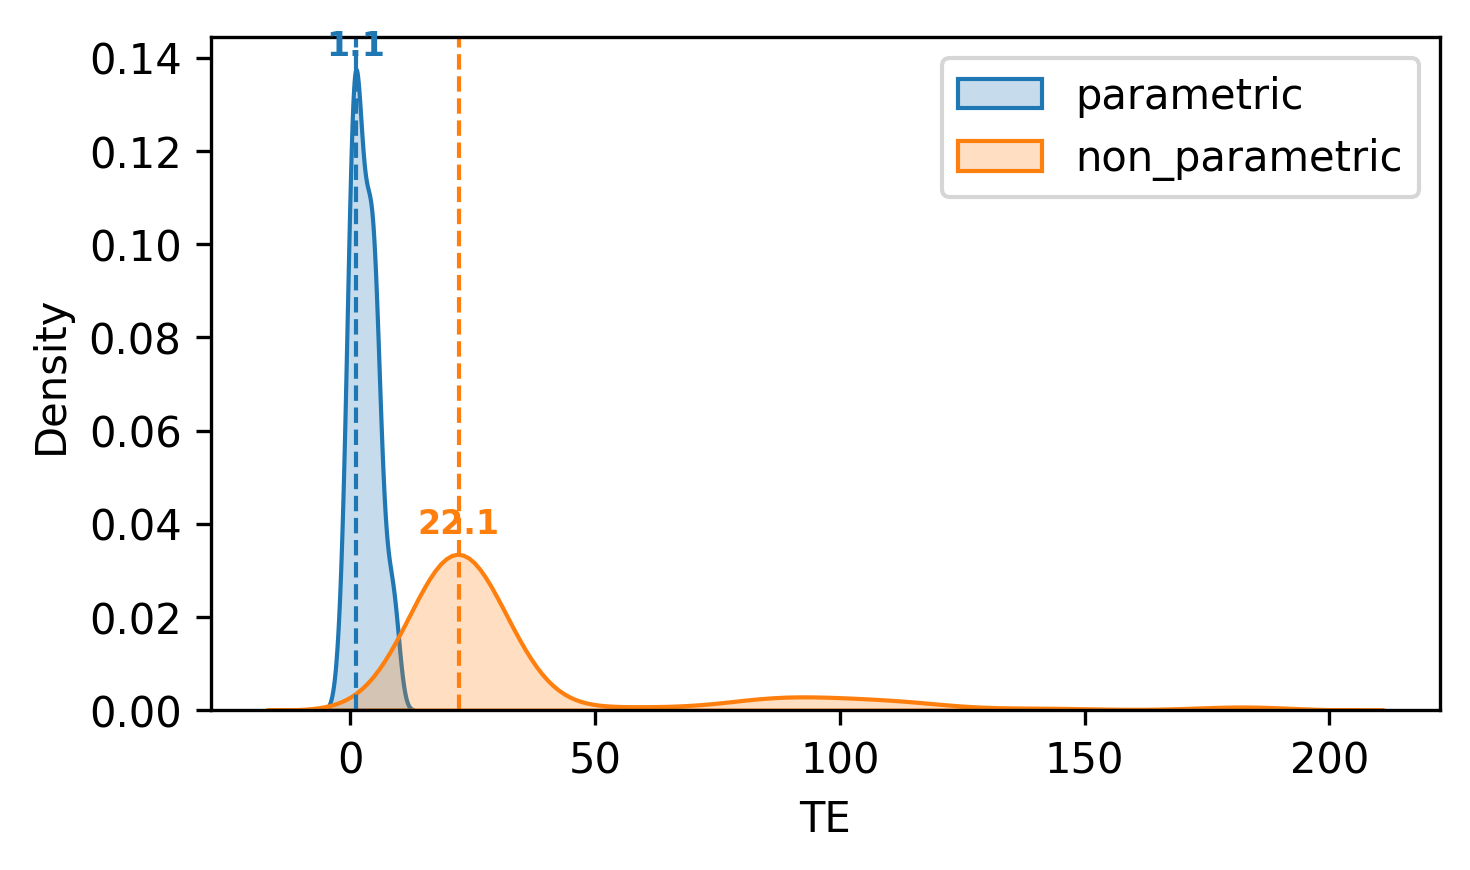

In [13]:
save_dir = "../data/figures/real_context/te/a_te_density_behaviors.pdf"
os.makedirs(os.path.dirname(save_dir), exist_ok=True)

df = pd.DataFrame(
    dict(
        [
            (k, pd.Series(v)) 
            for k, v in {
                "parametric": [r["te_log"].item() for topic in param_fa_data for r in param_fa_data[topic]],
                "non_parametric": [r["te_log"].item() for topic in nonparam_fa_data for r in nonparam_fa_data[topic]],
                # "vague": [r["te_log"].item() for topic in misc_fa_data for r in misc_fa_data[topic]],
            }.items()]
        )
    )

# Plotting combined KDE plot
plt.figure(figsize=(5, 3), dpi=300)  # Adjust the figure size as needed
colors = sns.color_palette("tab10", len(df.columns))

# for i, key in enumerate(df.columns):
#     sns.kdeplot(df[key].dropna(), fill=True, color=colors[i], label=key)

for i, key in enumerate(df.columns):
    data = df[key].dropna()
    sns.kdeplot(data, fill=True, color=colors[i], label=key)

    # Estimate the KDE and find the peak
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 300)
    y = kde(x)
    peak_index = np.argmax(y)
    peak_x = x[peak_index]  # Corresponding x value
    peak_y = y[peak_index]  # Peak y value

    # Add a vertical line at the peak
    plt.axvline(peak_x, color=colors[i], linestyle='--', linewidth=1)
    plt.text(peak_x, peak_y + 0.0015 * (i + 1), f'{peak_x:.1f}', color=colors[i], ha='center', va='bottom', fontsize=8, weight='bold')


plt.legend(loc='best')
plt.xlabel('TE')
plt.ylabel('Density')
# plt.title('TE Density for Parametric, Non-Parametric and Misc Behaviors')
plt.tight_layout()
plt.savefig(save_dir, bbox_inches="tight")
plt.show()

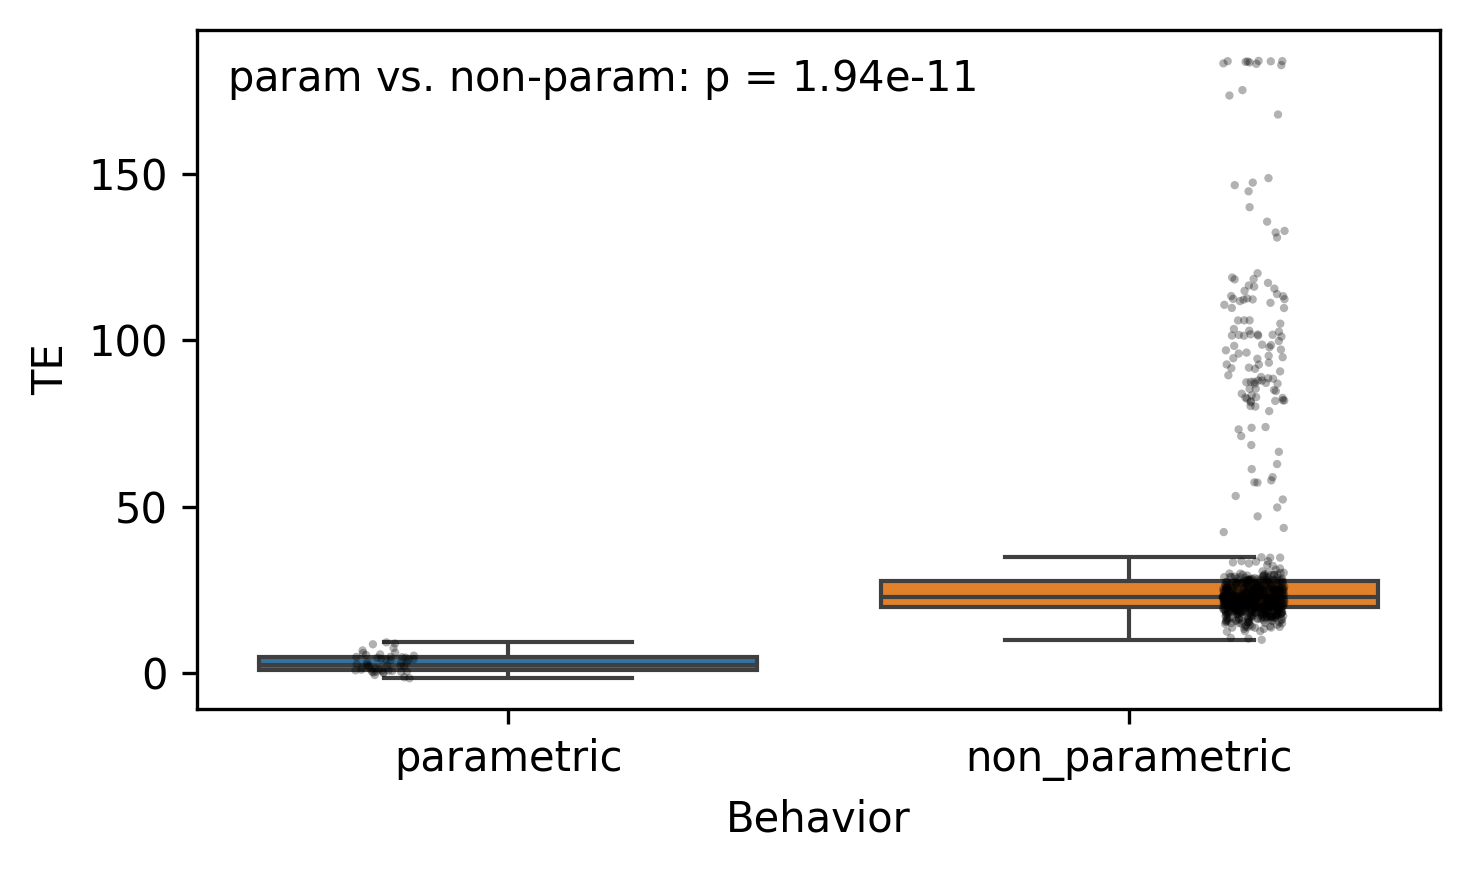

In [14]:
save_dir = "../data/figures/real_context/te/a_te_statistical_overlay_behaviors.pdf"
os.makedirs(os.path.dirname(save_dir), exist_ok=True)

df = pd.DataFrame(
    dict(
        [
            (k, pd.Series(v)) 
            for k, v in {
                "parametric": [r["te_log"].item() for topic in param_fa_data for r in param_fa_data[topic]],
                "non_parametric": [r["te_log"].item() for topic in nonparam_fa_data for r in nonparam_fa_data[topic]],
                # "vague": [r["te_log"].item() for topic in misc_fa_data for r in misc_fa_data[topic]],
            }.items()]
        )
    )

colors = sns.color_palette("tab10", len(df.columns))
df_melted = pd.melt(df, var_name='Behavior', value_name='TE')

# Set the colors to match the previous visualization
_colors = {'parametric': '#000000', 'non_parametric': '#000000'}

plt.figure(figsize=(5, 3), dpi=300) 
# sns.boxplot(x='Behavior', y='TE', data=df_melted, hue='Behavior', palette=colors, showfliers=False, dodge=False, legend=False)
sns.boxplot(x='Behavior', y='TE', data=df_melted, hue='Behavior', palette=colors, showfliers=False)

# Overlaying scatter points with the updated approach
sns.stripplot(x='Behavior', y='TE', data=df_melted, hue='Behavior', palette=_colors, jitter=True, dodge=True, alpha=0.3, size=2, legend=False)

# Perform a t-test
t_stat, p_val = ttest_ind(df['parametric'].dropna(), df['non_parametric'].dropna())
plt.text(0.15, max(df_melted['TE']) * 0.95, f'$\\text{{param vs. non-param}}$: p = {p_val:.2e}', ha='center', color='black', fontsize=10)




plt.xlabel('Behavior')
plt.ylabel('TE')
plt.tight_layout()
plt.savefig(save_dir, bbox_inches="tight")
plt.show()


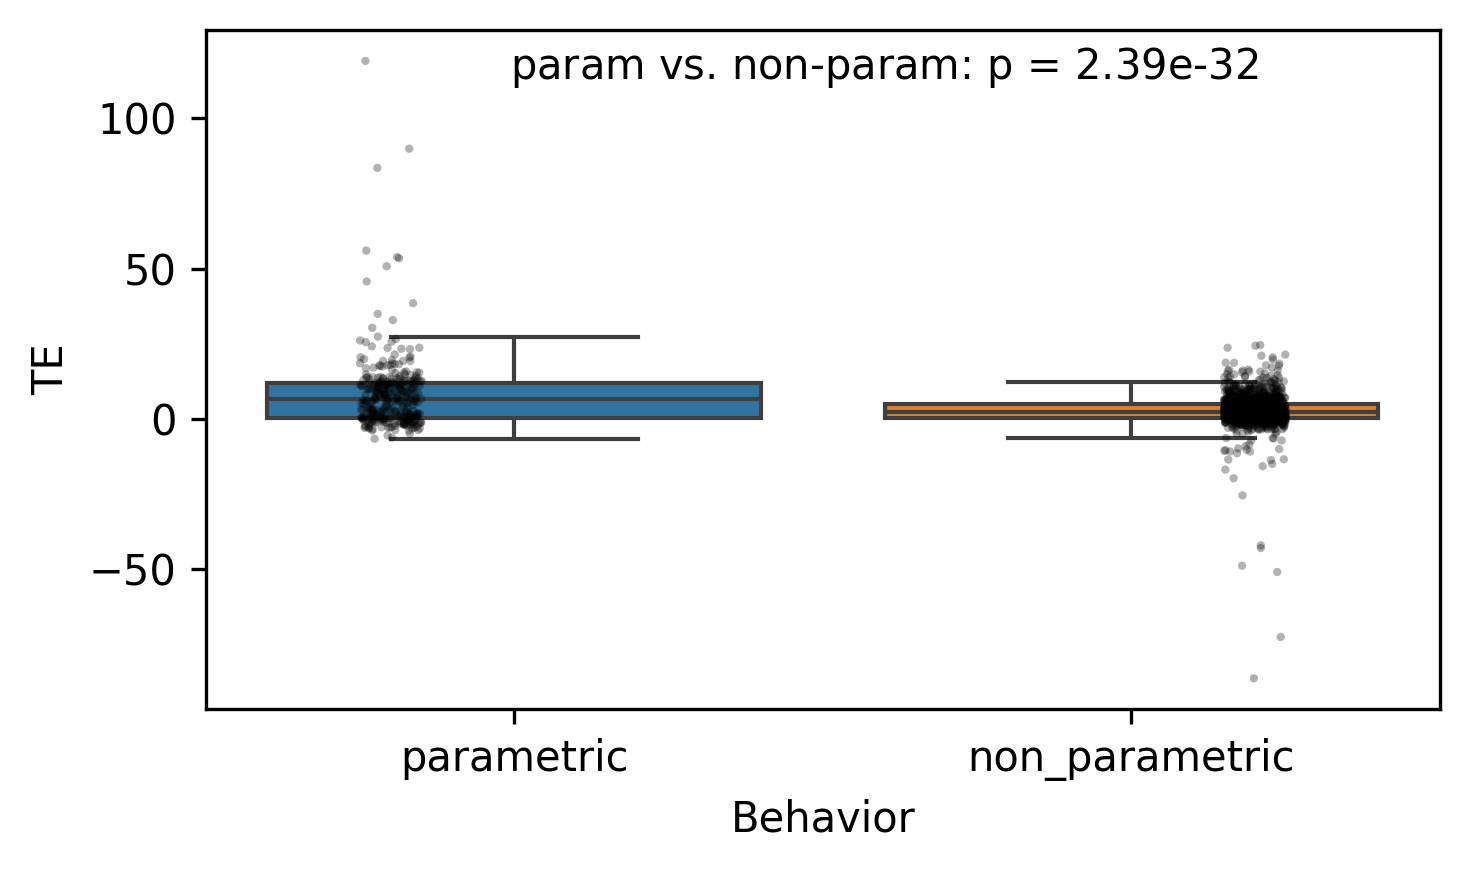

In [15]:
save_dir = "../data/figures/real_context/te/b_te_statistical_overlay_behaviors.pdf"
os.makedirs(os.path.dirname(save_dir), exist_ok=True)

df = pd.DataFrame(
    dict(
        [
            (k, pd.Series(v)) 
            for k, v in {
                "parametric": [r["te_log"].item() for topic in param_fb_data for r in param_fb_data[topic]],
                "non_parametric": [r["te_log"].item() for topic in nonparam_fb_data for r in nonparam_fb_data[topic]],
                # "vague": [r["te_log"].item() for topic in misc_fb_data for r in misc_fb_data[topic]],
            }.items()]
        )
    )

colors = sns.color_palette("tab10", len(df.columns))
df_melted = pd.melt(df, var_name='Behavior', value_name='TE')

# Set the colors to match the previous visualization
_colors = {'parametric': '#000000', 'non_parametric': '#000000'}

plt.figure(figsize=(5, 3), dpi=300) 
# sns.boxplot(x='Behavior', y='TE', data=df_melted, hue='Behavior', palette=colors, showfliers=False, dodge=False, legend=False)
sns.boxplot(x='Behavior', y='TE', data=df_melted, hue='Behavior', palette=colors, showfliers=False)

# Overlaying scatter points with the updated approach
sns.stripplot(x='Behavior', y='TE', data=df_melted, hue='Behavior', palette=_colors, jitter=True, dodge=True, alpha=0.3, size=2, legend=False)

# Perform a t-test
t_stat, p_val = ttest_ind(df['parametric'].dropna(), df['non_parametric'].dropna())
plt.text(0.6, max(df_melted['TE']) * 0.95, f'$\\text{{param vs. non-param}}$: p = {p_val:.2e}', ha='center', color='black', fontsize=10)



plt.xlabel('Behavior')
plt.ylabel('TE')
plt.tight_layout()
plt.savefig(save_dir, bbox_inches="tight")
plt.show()


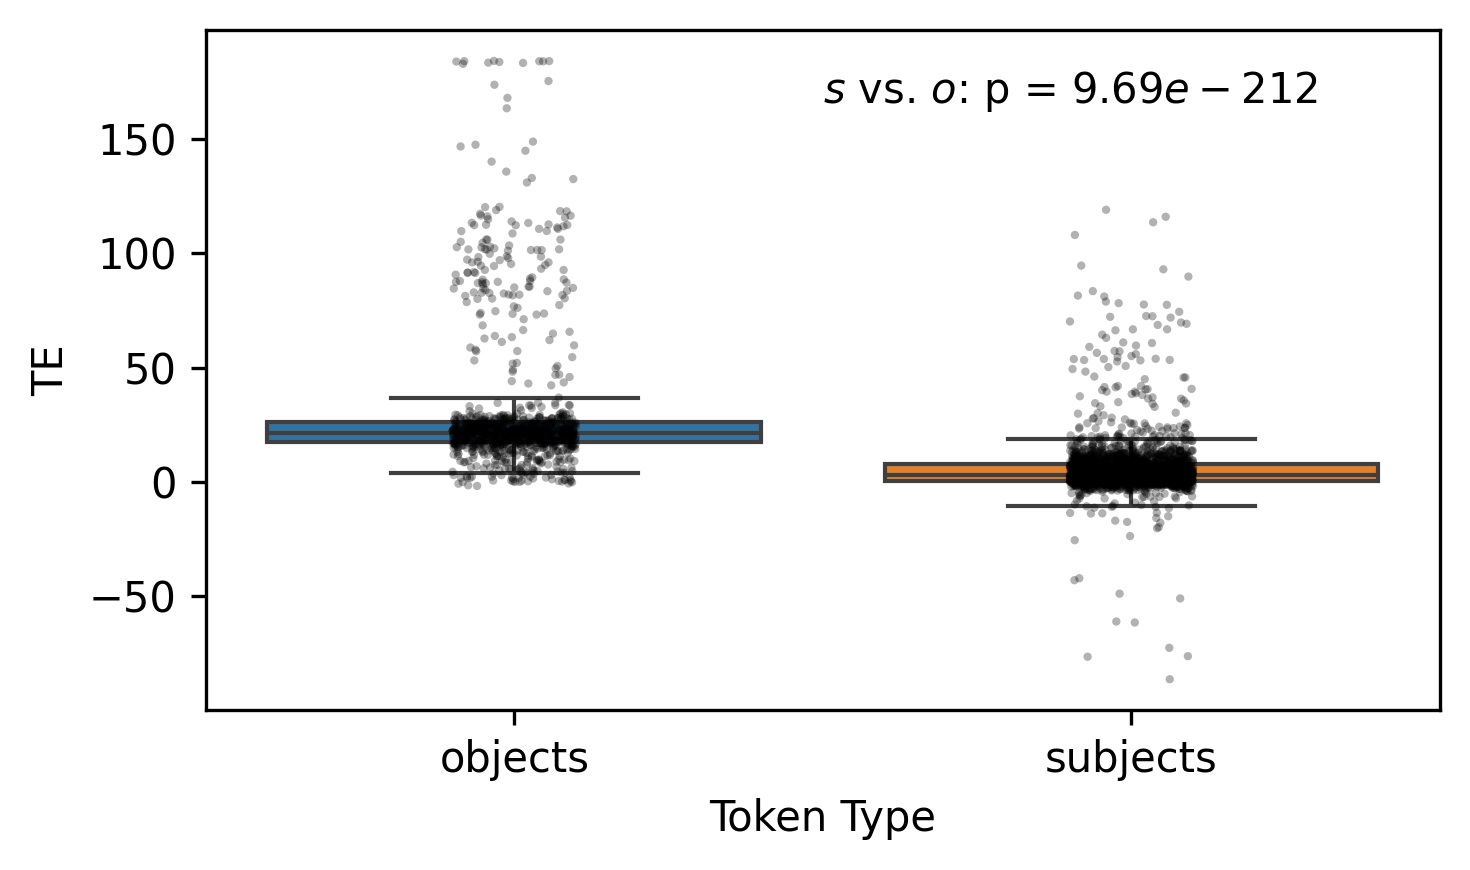

In [16]:
save_dir = "../data/figures/real_context/te/abc_te_statistical_overlay_tokentypes.pdf"
os.makedirs(os.path.dirname(save_dir), exist_ok=True)


data = {
    "object_tokens": [item["te_log"].item() for topic in none_a_data for item in none_a_data[topic]],
    "subject_tokens": [item["te_log"].item() for topic in none_b_data for item in none_b_data[topic]],
}

# Creating a DataFrame with token types
df = pd.DataFrame({
    'TE': data['object_tokens'] + data['subject_tokens'],
    'TokenType': ['objects'] * len(data['object_tokens']) + 
                 ['subjects'] * len(data['subject_tokens'])
})

# Define the colors for each token type
colors = sns.color_palette("tab10", len(data.keys()))
_colors = {key.replace("_tokens", "") + "s": '#000000' for key in data.keys()}

# Plotting the box plot with scatter overlay
plt.figure(figsize=(5, 3), dpi=300) 
sns.boxplot(x='TokenType', y='TE', data=df, palette=colors, showfliers=False,  hue='TokenType', dodge=False)
sns.stripplot(x='TokenType', y='TE', data=df, palette=_colors, jitter=True, dodge=False, alpha=0.3, size=2, hue='TokenType', legend=False)

# Performing t-tests between each pair of token types
subject_vs_object = ttest_ind(df[df['TokenType'] == 'subjects']['TE'], df[df['TokenType'] == 'objects']['TE'])

# Annotating t-test results on the plot
# plt.text(-0.4, max(df['TE']) * 0.9, f'Subject vs Object p = {subject_vs_object.pvalue:.2e}')
# plt.text(-0.4, max(df['TE']) * 0.8, f'Subject vs Relation p = {subject_vs_relation.pvalue:.2e}')
# plt.text(-0.4, max(df['TE']) * 0.7, f'Object vs Relation p = {object_vs_relation.pvalue:.2e}')
plt.text(0.5, max(df['TE']) * 0.9, fr'$s$ vs. $o$: p = ${subject_vs_object.pvalue:.2e}$', fontsize=10)

plt.xlabel('Token Type')
plt.ylabel('TE')
plt.tight_layout()
plt.savefig(save_dir, bbox_inches="tight")
plt.show()


In [17]:
raw_a_data = {
    kind: retrieve_behaviors(read_data(adata, experiment_type="a", kind=kind), threshold=-1, pnp_threshold=6)
    for kind in [None, "mlp", "attn"]
}
print()
raw_b_data = {
    kind: retrieve_behaviors(read_data(bdata, experiment_type="b", kind=kind), threshold=-1, pnp_threshold=6)
    for kind in [None, "mlp", "attn"]
}

100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


In [18]:
def plot_r(r, labels, title, experiment_type, kind=None, q_type=None, savepdf=None, show_plots=False):
    fig, axs = plt.subplots(1, 1, figsize=(4, 2.2), dpi=300)
    plt.title(title + (f" [{q_type}]" if q_type else ""))
    plot_array(
        r,
        ax=axs,
        labels=labels,
        kind=kind,
        low_score=r.min(),
        high_score=r.max(),
        show_y_labels=True,
        archname="Atlas",
        savepdf=os.path.join(savepdf, f"avg_exp_{experiment_type}_{kind}.pdf") if savepdf else None
    )

    if show_plots:
        plt.show()
    else:
        plt.close()


def plot_r_layer_contribution(r, title, experiment_type, kind=None, savepdf=None, show_plots=False, num_layers=12):
    color_maps = {
        None: "Purples",
        "mlp": "Greens",
        "attn": "Reds"
    }
    
    avg_contrib = np.mean(r, axis=0)

    plt.figure(figsize=(4, 3), dpi=300)
    bars = plt.bar(range(0, num_layers), avg_contrib, color=plt.get_cmap(color_maps[kind])(np.linspace(0.3, 0.7, 12)))
    
    plt.xlabel('Layers')
    plt.ylabel('AIE')
    plt.title(title)
    plt.xticks(range(0, num_layers))
    plt.yticks()

    for bar, value in zip(bars, avg_contrib):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.08, f'{value:.2f}', ha='center', va='bottom', rotation=90)

    plt.ylim(0, avg_contrib.max() + 1.0)
    plt.tight_layout()
    if savepdf:
        plt.savefig(f"{savepdf}/avg_exp_{experiment_type}_{kind}_lwc.pdf")

    if show_plots:
        plt.show()
    else:
        plt.close()


def do_figures(
    raw_data, 
    experiment_type, 
    behavior="param", 
    savepdf=None, 
    q_type=None, 
    show_heatmap_plots=False,
    show_contrib_plots=False,
    do_log=True,
):

    heatmap_whate = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }
    contrib_what = {
        None: "$h_i^{(l)}$",
        "mlp": "MLP",
        "attn": "Attn",
    }

    for kind in [None, "mlp", "attn"]:
        if behavior == "all":
            experiments = []
            for b in ["param", "non_param", "misc"]:
                for k, v in raw_data[kind][b].items():
                    for r in v:
                        experiments.append(r)
        else:
            experiments = [r for k, v in raw_data[kind][behavior].items() for r in v]
        
        
        data = tokens_space_division(experiments, experiment_type=experiment_type, do_log=do_log)    
        r = np.clip(data["result"], 0, None)
        if r.size == 0:
            continue
        
        plot_r(
            r, 
            data["labels"],
            title=f"Avg {heatmap_whate[kind]} over {len(experiments)} prompts" + (f" [{q_type}]" if q_type else ""), 
            kind=kind,
            experiment_type=experiment_type, 
            q_type=q_type, 
            savepdf=savepdf, 
            show_plots=show_heatmap_plots
        )

        plot_r_layer_contribution(
            r, 
            title=f'Layer Contribution of {contrib_what[kind]}' + (f" [{q_type}]" if q_type else ""), 
            experiment_type=experiment_type, 
            kind=kind, 
            savepdf=savepdf, 
            show_plots=show_contrib_plots,
            num_layers=12,
        )


In [19]:
print(raw_a_data.keys())
print(raw_a_data[None].keys())
print(raw_a_data[None]["param"].keys())

dict_keys([None, 'mlp', 'attn'])
dict_keys(['param', 'non_param', 'misc'])
dict_keys(['causal_trace/popqa/capital', 'causal_trace/popqa/capital_of', 'causal_trace/popqa/color', 'causal_trace/popqa/country', 'causal_trace/popqa/place_of_birth', 'causal_trace/popqa/religion', 'causal_trace/peq/P17', 'causal_trace/peq/P19', 'causal_trace/peq/P20', 'causal_trace/peq/P106', 'causal_trace/peq/P131', 'causal_trace/peq/P176', 'causal_trace/peq/P276', 'causal_trace/peq/P407', 'causal_trace/peq/P495', 'causal_trace/peq/P740'])


In [20]:
behavior = "param"
savepdf = f"../data/figures/real_context/{behavior}/avg_datasets"
os.makedirs(savepdf, exist_ok=True)

print('---' * 10, 'EXP A', '---' * 10)
experiment_type = "a"
exp_a = do_figures(
    raw_a_data, 
    experiment_type, 
    behavior=behavior,
    savepdf=savepdf, 
    q_type=None,
    show_heatmap_plots=False,
    show_contrib_plots=False
)

print('---' * 10, 'EXP B', '---' * 10)
experiment_type = "b"
exp_b = do_figures(
    raw_b_data, 
    experiment_type, 
    behavior=behavior,
    savepdf=savepdf, 
    q_type=None,
    show_heatmap_plots=False,
    show_contrib_plots=False
)

------------------------------ EXP A ------------------------------


100%|██████████| 49/49 [00:00<00:00, 651.33it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 340/340 [00:01<00:00, 259.27it/s]


In [21]:
behavior = "non_param"
savepdf = f"../data/figures/real_context/{behavior}/avg_datasets"
os.makedirs(savepdf, exist_ok=True)

print('---' * 10, 'EXP A', '---' * 10)
experiment_type = "a"
exp_a = do_figures(
    raw_a_data, 
    experiment_type, 
    behavior=behavior,
    savepdf=savepdf, 
    q_type=None,
    show_heatmap_plots=False,
    show_contrib_plots=False
)

print('---' * 10, 'EXP B', '---' * 10)
experiment_type = "b"
exp_b = do_figures(
    raw_b_data, 
    experiment_type, 
    behavior=behavior,
    savepdf=savepdf, 
    q_type=None,
    show_heatmap_plots=False,
    show_contrib_plots=False
)

------------------------------ EXP A ------------------------------


100%|██████████| 751/751 [00:06<00:00, 121.59it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 1361/1361 [00:21<00:00, 62.06it/s]


------------------------------ EXP A ------------------------------


100%|██████████| 1044/1044 [00:12<00:00, 81.89it/s]


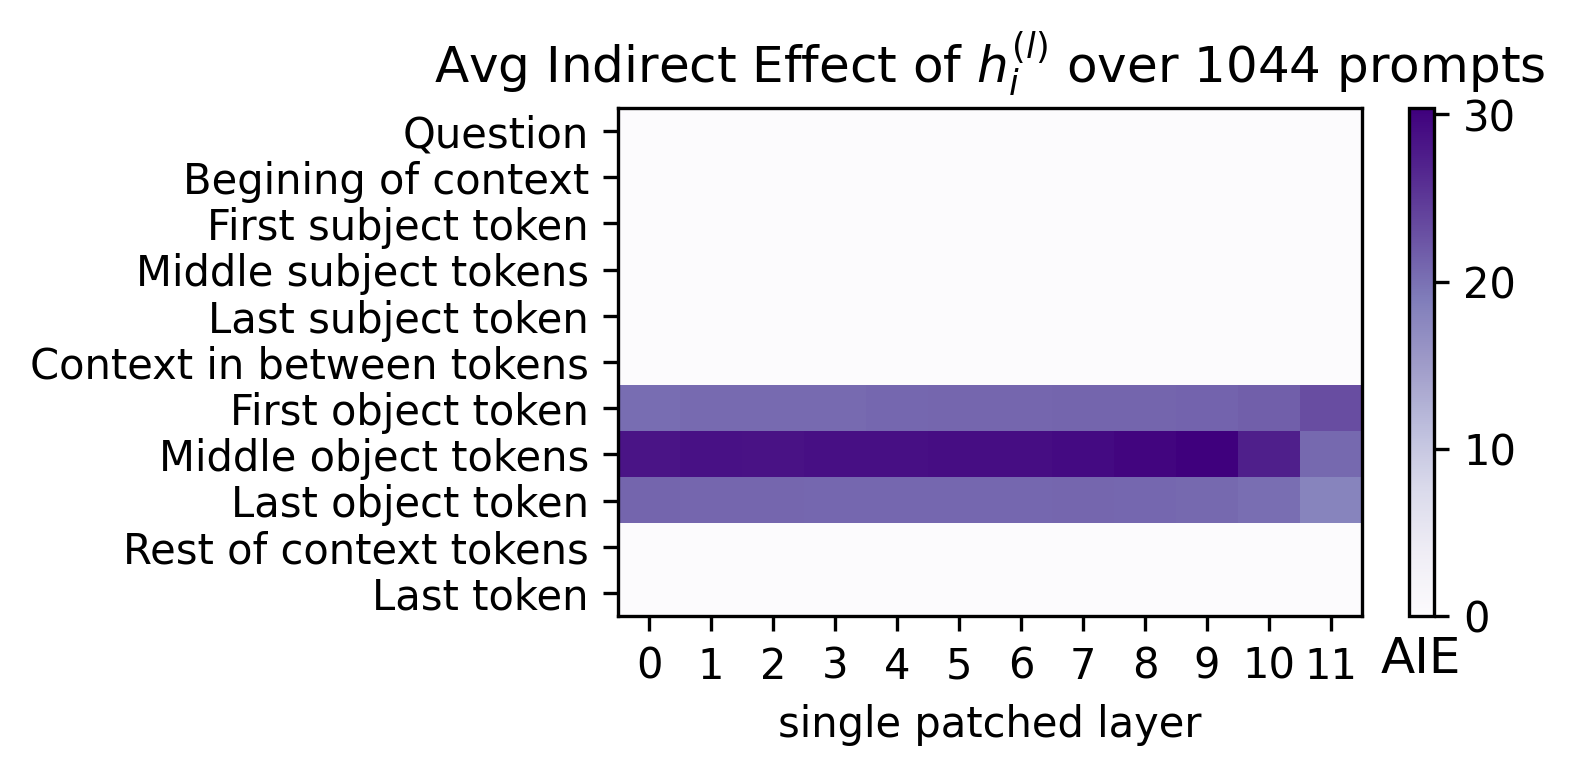

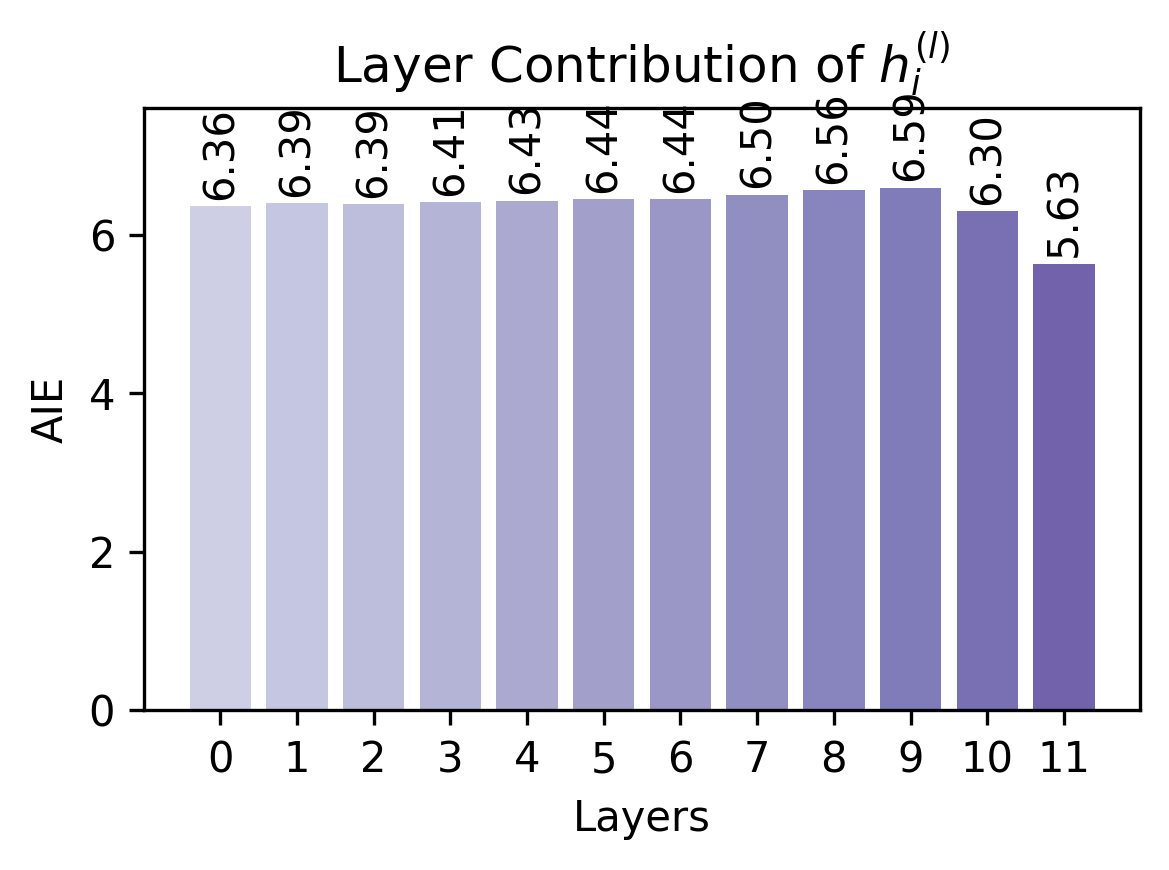

100%|██████████| 1044/1044 [00:12<00:00, 83.21it/s]


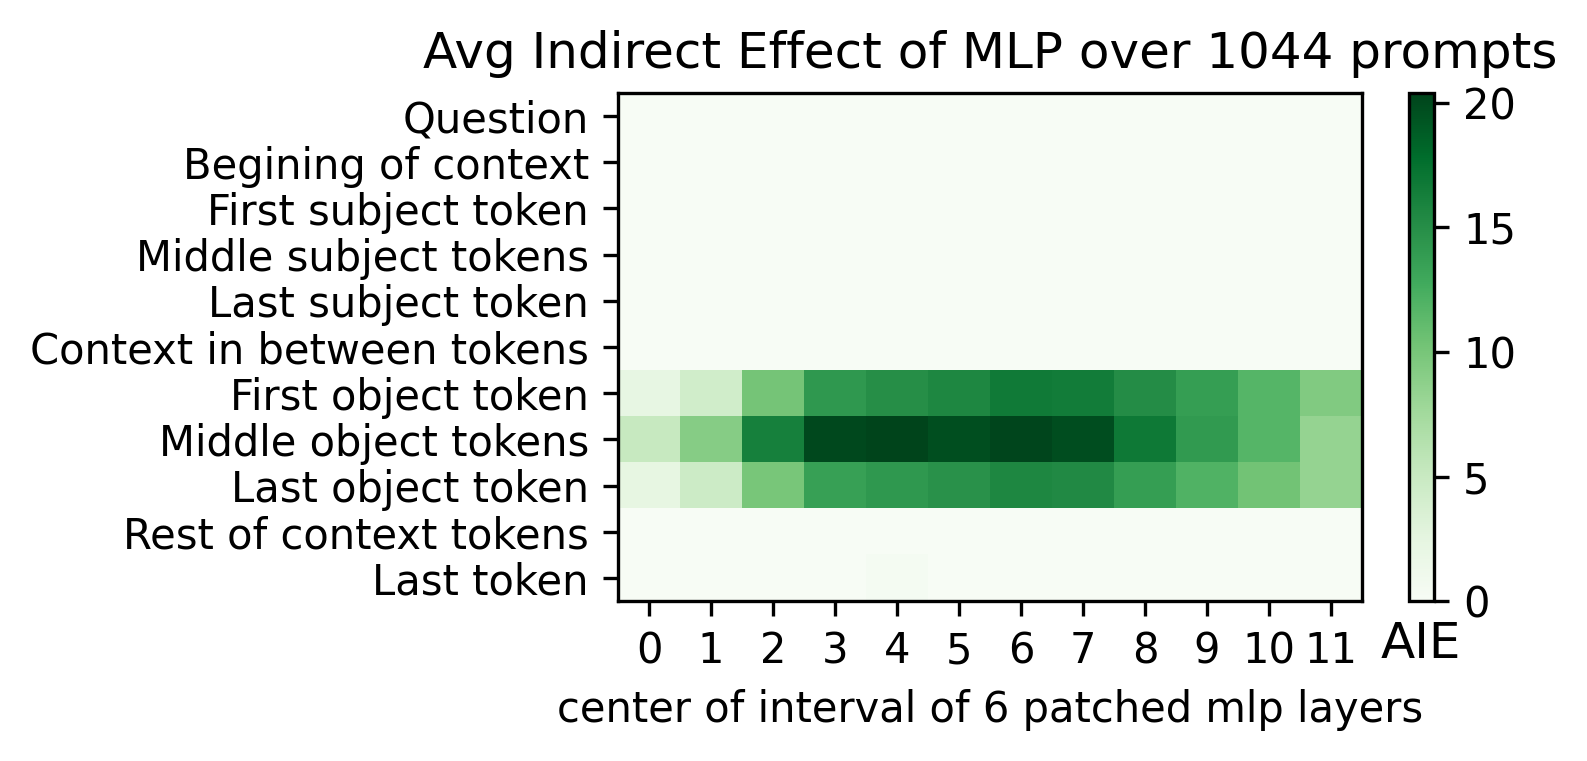

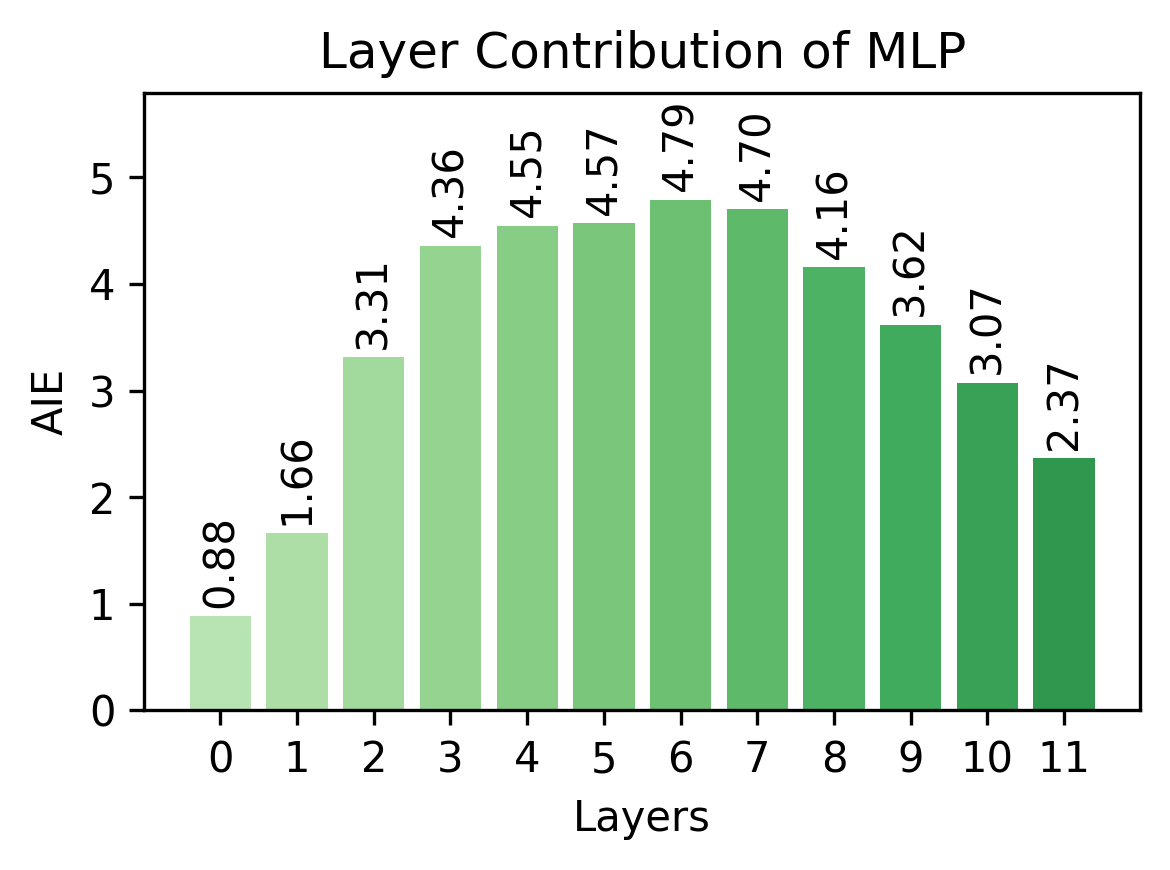

100%|██████████| 1044/1044 [00:12<00:00, 83.78it/s]


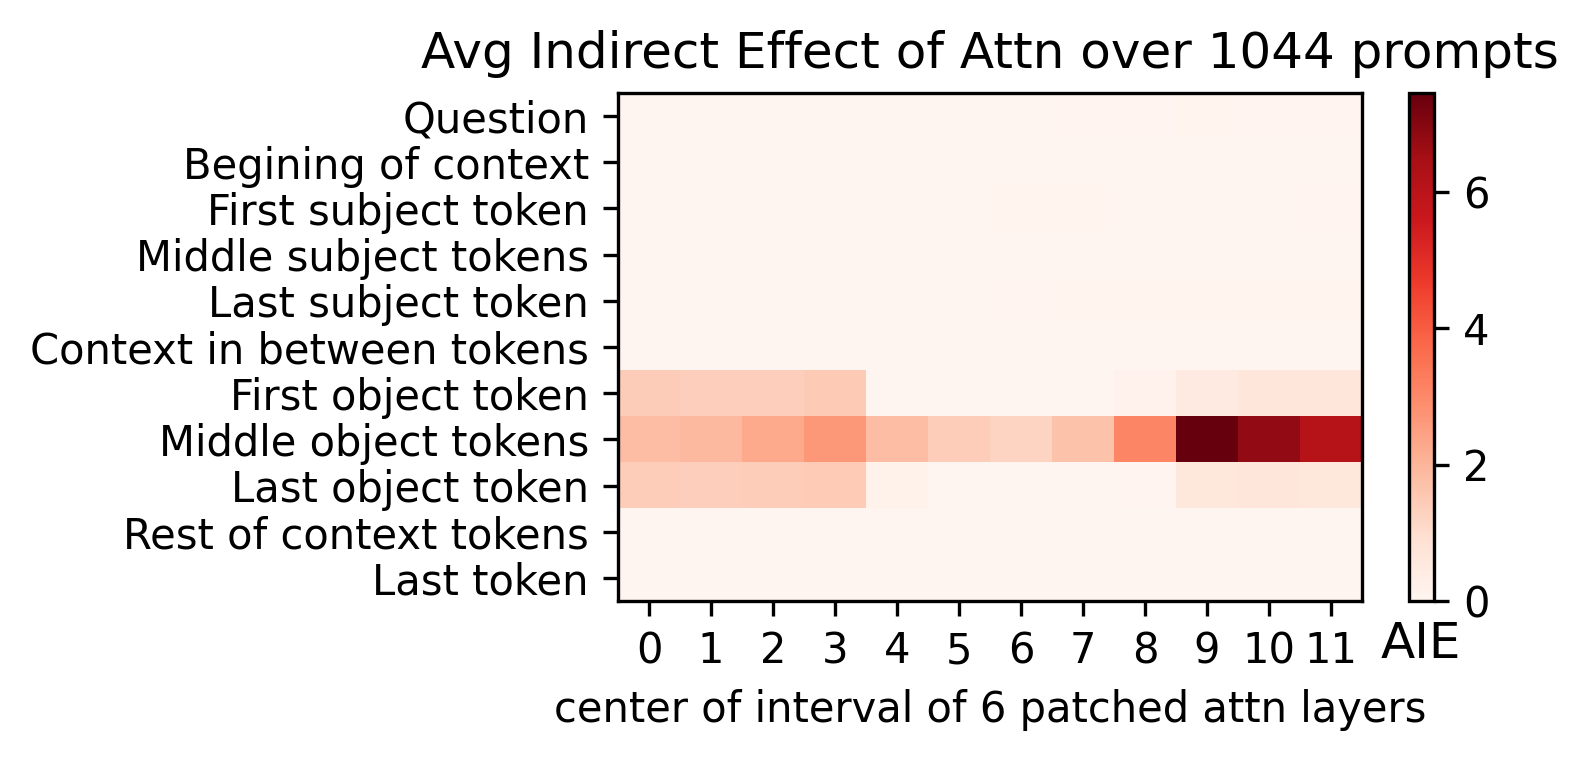

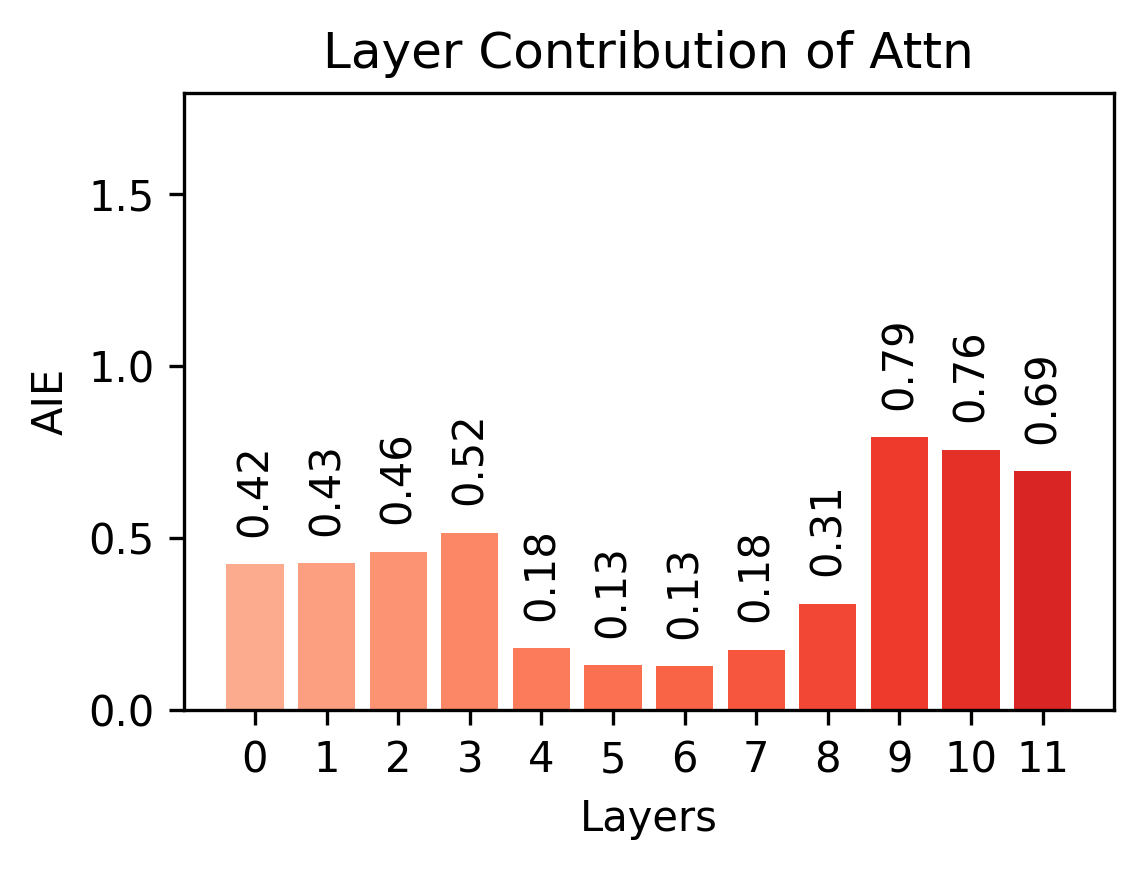

------------------------------ EXP B ------------------------------


100%|██████████| 2341/2341 [01:08<00:00, 33.99it/s]


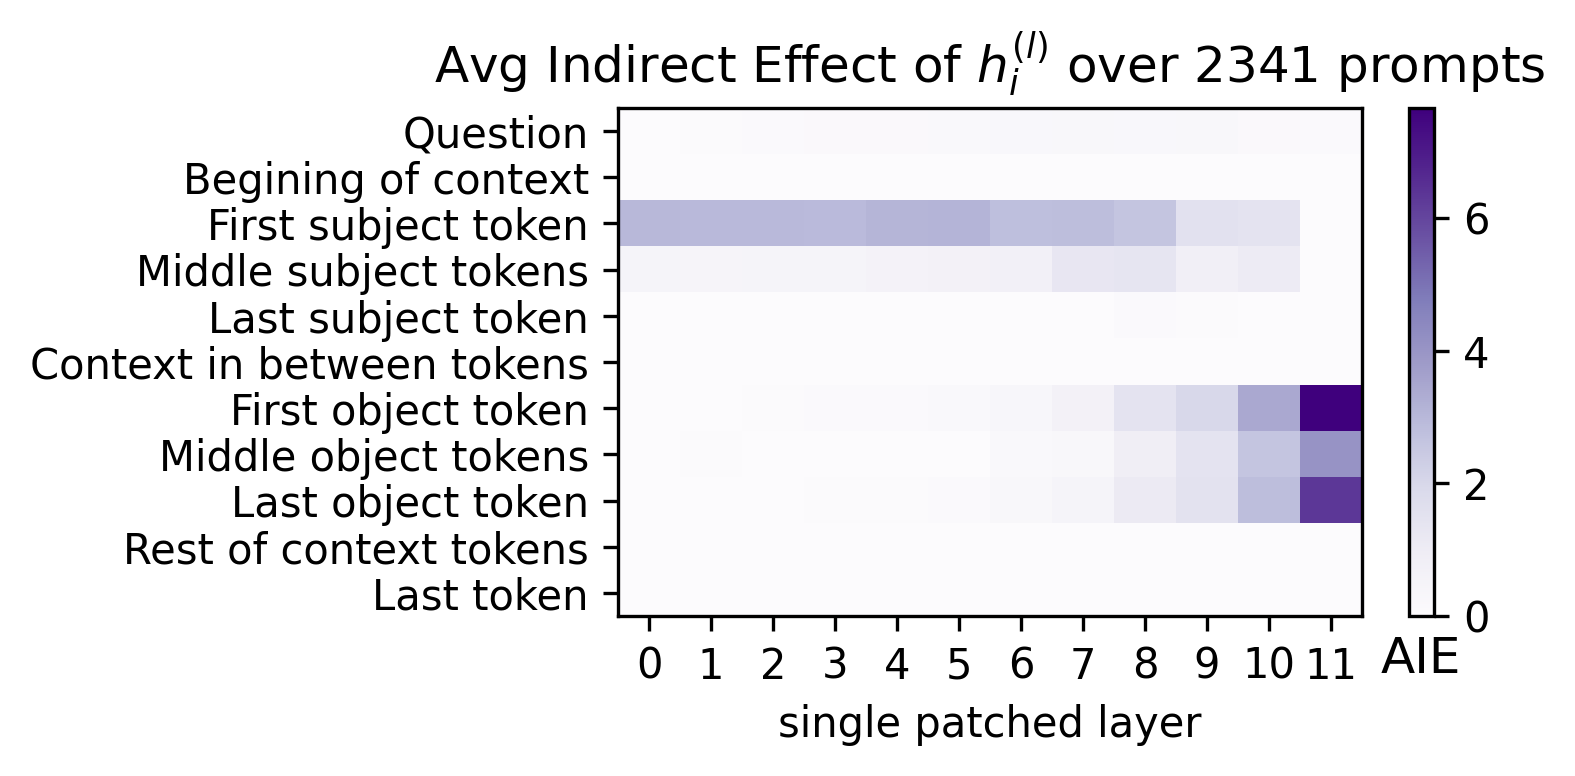

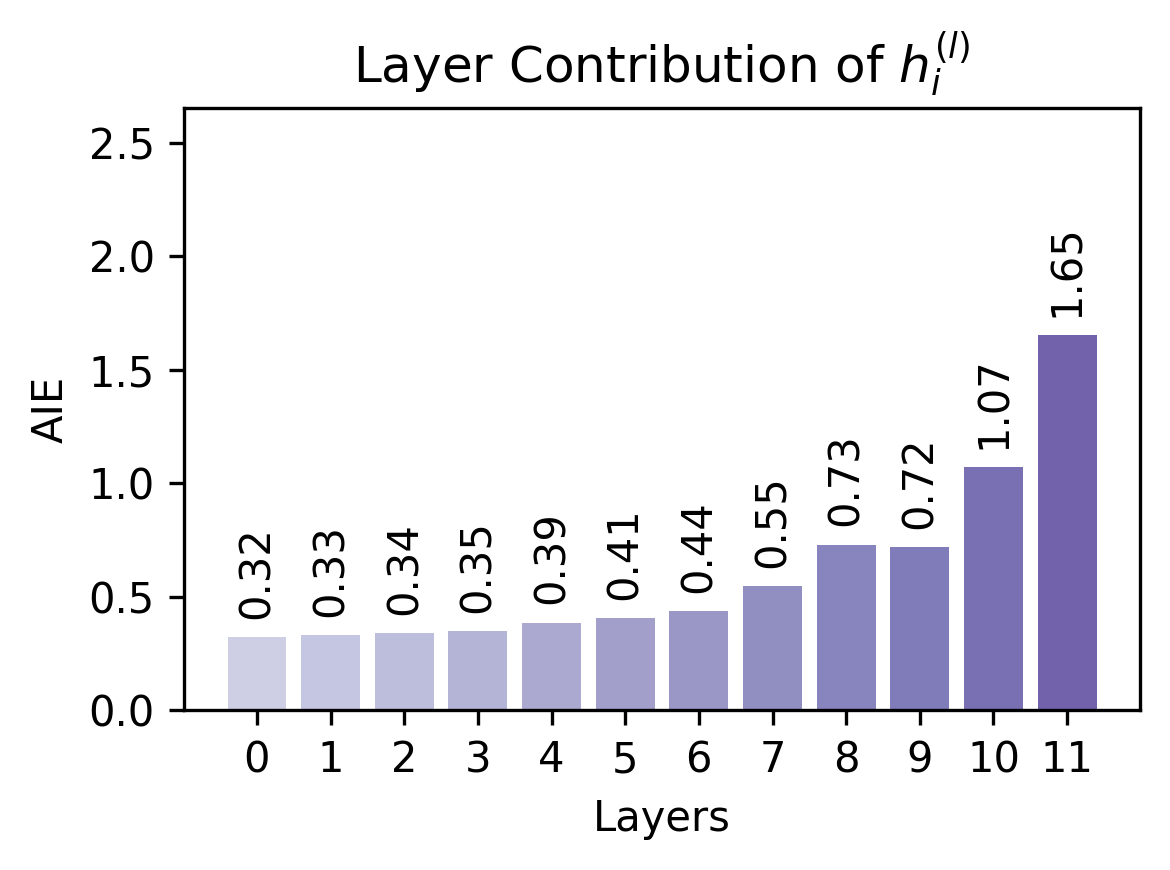

100%|██████████| 2341/2341 [01:08<00:00, 34.00it/s]


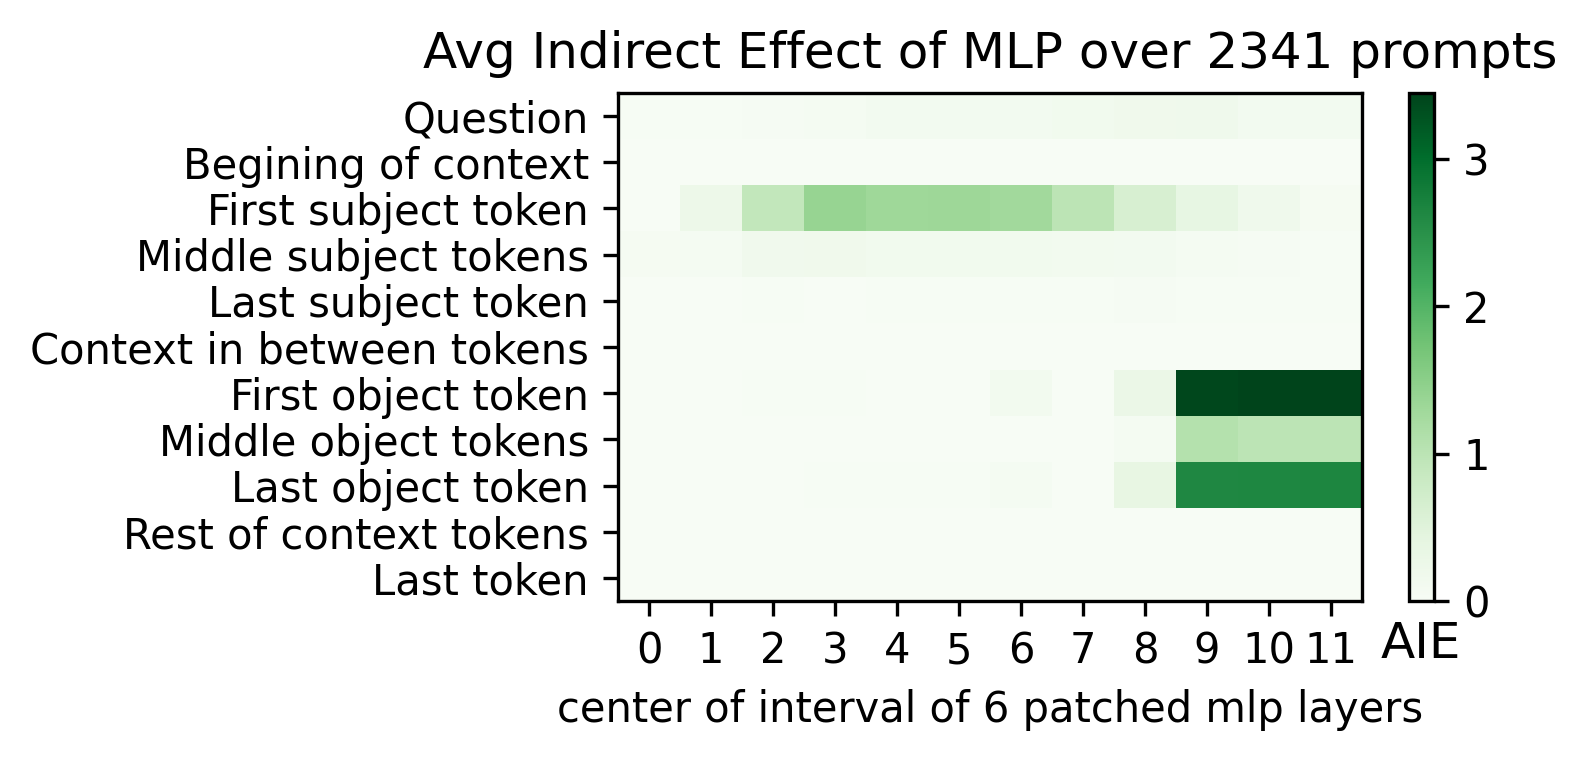

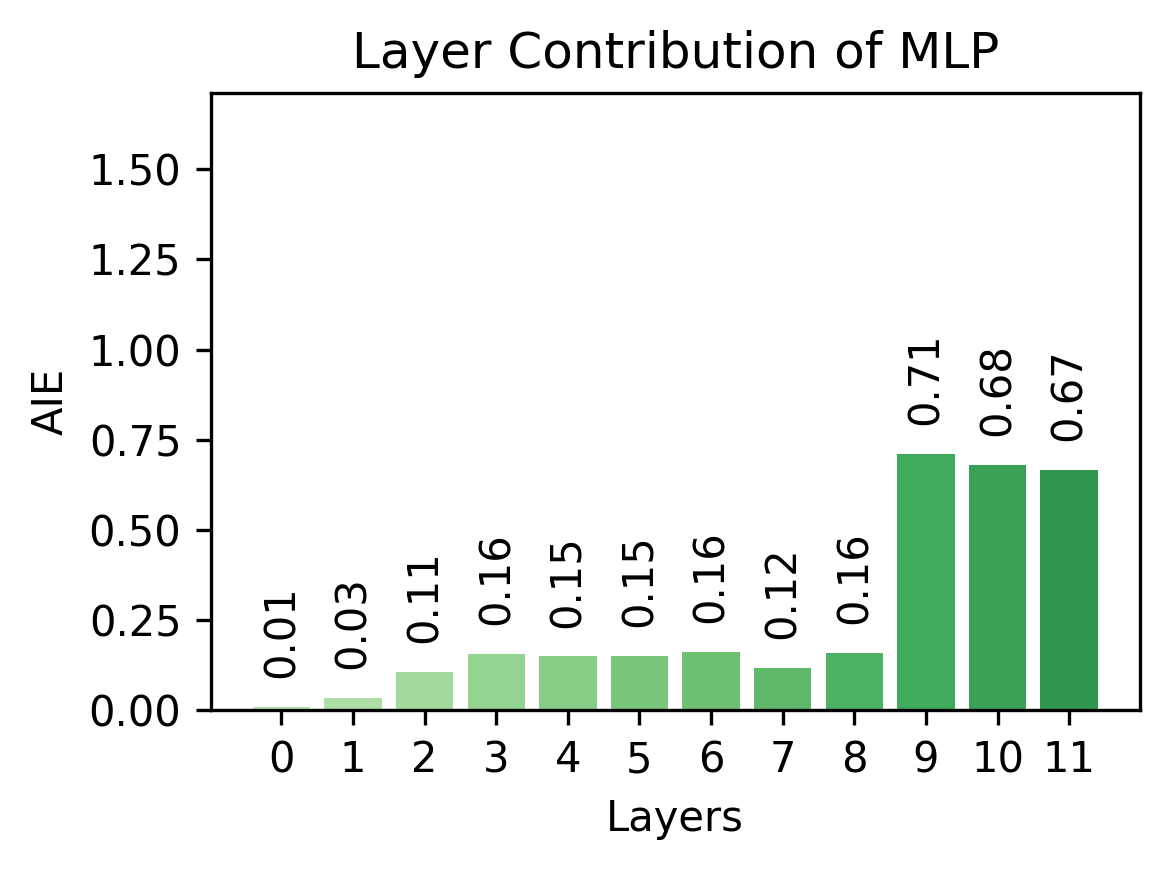

100%|██████████| 2341/2341 [01:09<00:00, 33.74it/s]


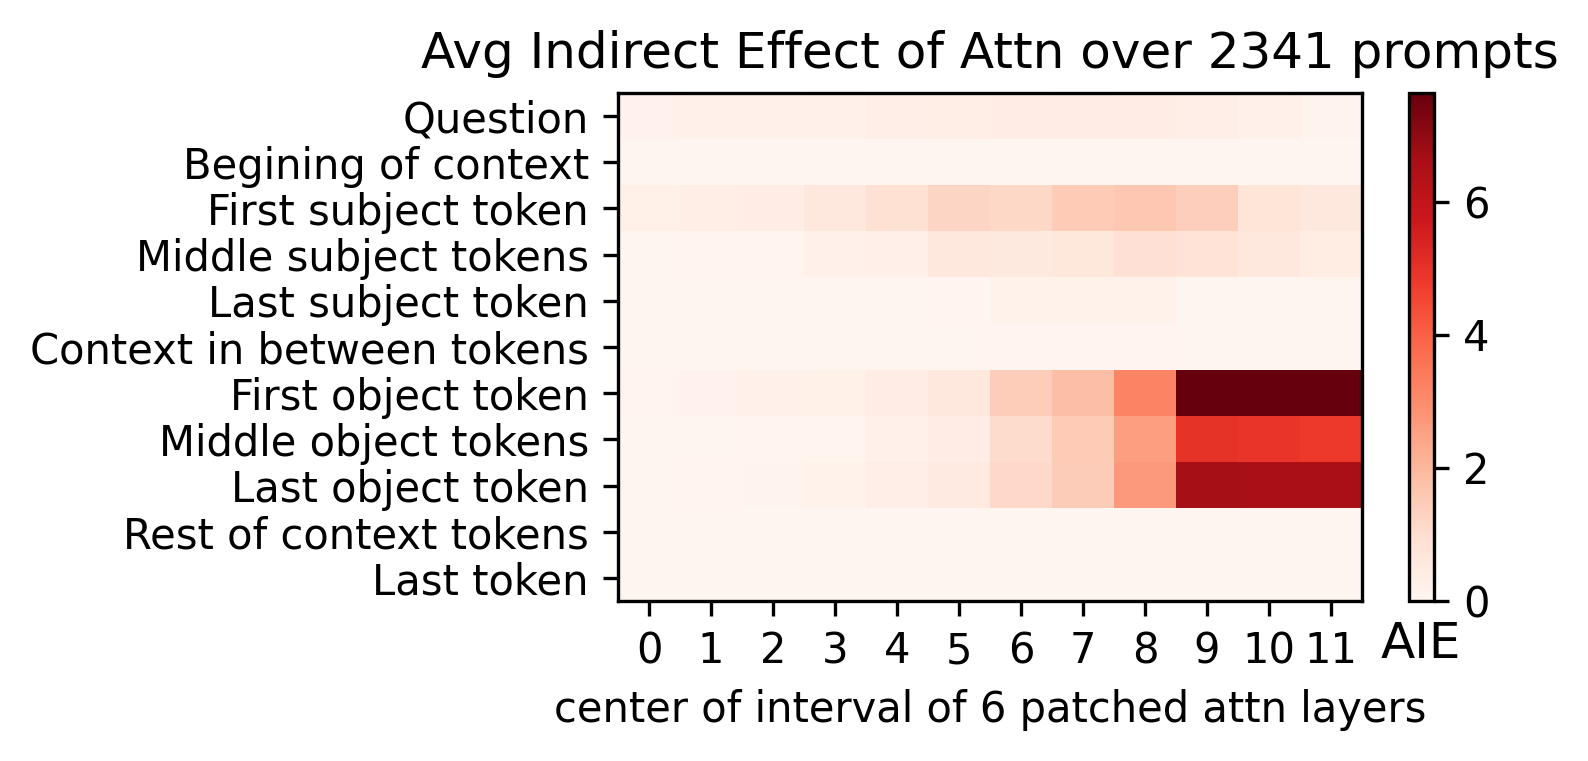

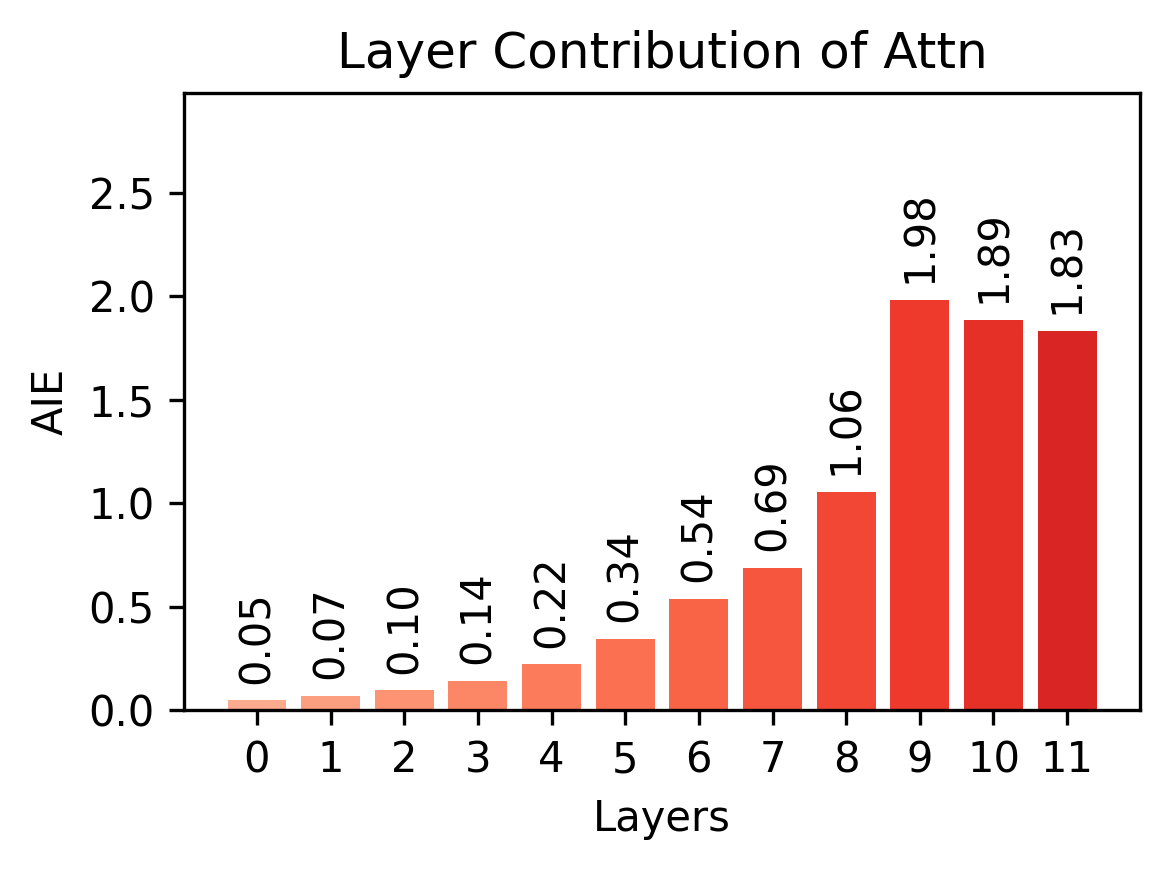

In [22]:
behavior = "all"
savepdf = f"../data/figures/real_context/{behavior}/avg_datasets"
os.makedirs(savepdf, exist_ok=True)

print('---' * 10, 'EXP A', '---' * 10)
experiment_type = "a"
exp_a = do_figures(
    raw_a_data, 
    experiment_type, 
    behavior=behavior,
    savepdf=savepdf, 
    q_type=None,
    show_heatmap_plots=True,
    show_contrib_plots=True
)

print('---' * 10, 'EXP B', '---' * 10)
experiment_type = "b"
exp_b = do_figures(
    raw_b_data, 
    experiment_type, 
    behavior=behavior,
    savepdf=savepdf, 
    q_type=None,
    show_heatmap_plots=True,
    show_contrib_plots=True
)

In [23]:
print(raw_a_data.keys())
print(raw_a_data[None].keys())
print("\n".join(raw_a_data[None]["non_param"].keys()))

dict_keys([None, 'mlp', 'attn'])
dict_keys(['param', 'non_param', 'misc'])
causal_trace/popqa/capital
causal_trace/popqa/capital_of
causal_trace/popqa/color
causal_trace/popqa/country
causal_trace/popqa/place_of_birth
causal_trace/popqa/religion
causal_trace/peq/P17
causal_trace/peq/P19
causal_trace/peq/P20
causal_trace/peq/P106
causal_trace/peq/P131
causal_trace/peq/P176
causal_trace/peq/P276
causal_trace/peq/P407
causal_trace/peq/P495
causal_trace/peq/P740


In [24]:
qs = [
    'causal_trace/popqa/capital',
    'causal_trace/popqa/capital_of',
    'causal_trace/popqa/color',
    'causal_trace/popqa/country',
    'causal_trace/popqa/place_of_birth',
    'causal_trace/popqa/religion',

    "causal_trace/peq/P17",
    "causal_trace/peq/P19",
    "causal_trace/peq/P20",
    "causal_trace/peq/P106",
    "causal_trace/peq/P131",
    "causal_trace/peq/P176",
    "causal_trace/peq/P276",
    "causal_trace/peq/P407",
    "causal_trace/peq/P495",
    "causal_trace/peq/P740",
]

behavior = "param"
for q in qs:
    print(f"QUESTION TYPE: {q}")
    go_to_next = False

    for kind in [None, "mlp", "attn"]:
        if q not in raw_a_data[kind][behavior] or len(raw_a_data[kind][behavior][q]) == 0:
            go_to_next = True

    if go_to_next:
        continue

    q_type = q.split("/")[-1]
    
    new_raw_a_data = {kind: {behavior: {q: raw_a_data[kind][behavior][q]}} for kind in [None, "mlp", "attn"]}
    new_raw_b_data = {kind: {behavior: {q: raw_b_data[kind][behavior][q]}} for kind in [None, "mlp", "attn"]}
    savepdf = f"../data/figures/real_context/{behavior}/avg_qs/{q_type}"
    os.makedirs(savepdf, exist_ok=True)

    print('---' * 10, 'EXP A', '---' * 10)
    experiment_type = "a"
    exp_a = do_figures(
        new_raw_a_data, 
        experiment_type, 
        behavior=behavior,
        savepdf=savepdf, 
        q_type=q_type,
    )

    print('---' * 10, 'EXP B', '---' * 10)
    experiment_type = "b"
    exp_b = do_figures(
        new_raw_b_data, 
        experiment_type, 
        behavior=behavior,
        savepdf=savepdf, 
        q_type=q_type,
    )

    # break

QUESTION TYPE: causal_trace/popqa/capital
------------------------------ EXP A ------------------------------


100%|██████████| 10/10 [00:00<00:00, 975.15it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 46/46 [00:00<00:00, 837.14it/s]


QUESTION TYPE: causal_trace/popqa/capital_of
------------------------------ EXP A ------------------------------


100%|██████████| 1/1 [00:00<00:00, 799.22it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 12/12 [00:00<00:00, 1050.68it/s]


QUESTION TYPE: causal_trace/popqa/color
------------------------------ EXP A ------------------------------


100%|██████████| 1/1 [00:00<00:00, 765.52it/s]


------------------------------ EXP B ------------------------------


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


QUESTION TYPE: causal_trace/popqa/country
------------------------------ EXP A ------------------------------


100%|██████████| 5/5 [00:00<00:00, 954.12it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 28/28 [00:00<00:00, 832.49it/s]


QUESTION TYPE: causal_trace/popqa/place_of_birth
QUESTION TYPE: causal_trace/popqa/religion
QUESTION TYPE: causal_trace/peq/P17
------------------------------ EXP A ------------------------------


100%|██████████| 6/6 [00:00<00:00, 927.84it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 57/57 [00:00<00:00, 868.95it/s]


QUESTION TYPE: causal_trace/peq/P19
QUESTION TYPE: causal_trace/peq/P20
QUESTION TYPE: causal_trace/peq/P106
QUESTION TYPE: causal_trace/peq/P131
QUESTION TYPE: causal_trace/peq/P176
QUESTION TYPE: causal_trace/peq/P276
------------------------------ EXP A ------------------------------


100%|██████████| 1/1 [00:00<00:00, 751.26it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 9/9 [00:00<00:00, 986.79it/s]


QUESTION TYPE: causal_trace/peq/P407
------------------------------ EXP A ------------------------------


100%|██████████| 19/19 [00:00<00:00, 855.93it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 137/137 [00:00<00:00, 435.39it/s]


QUESTION TYPE: causal_trace/peq/P495
------------------------------ EXP A ------------------------------


100%|██████████| 5/5 [00:00<00:00, 921.02it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 17/17 [00:00<00:00, 958.65it/s]


QUESTION TYPE: causal_trace/peq/P740
------------------------------ EXP A ------------------------------


100%|██████████| 1/1 [00:00<00:00, 689.74it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 12/12 [00:00<00:00, 1557.87it/s]


In [25]:
qs = [
    'causal_trace/popqa/capital',
    'causal_trace/popqa/capital_of',
    'causal_trace/popqa/color',
    'causal_trace/popqa/country',
    'causal_trace/popqa/place_of_birth',
    'causal_trace/popqa/religion',

    "causal_trace/peq/P17",
    "causal_trace/peq/P19",
    "causal_trace/peq/P20",
    "causal_trace/peq/P106",
    "causal_trace/peq/P131",
    "causal_trace/peq/P176",
    "causal_trace/peq/P276",
    "causal_trace/peq/P407",
    "causal_trace/peq/P495",
    "causal_trace/peq/P740",
]
behavior = "non_param"
for q in qs:
    print(f"QUESTION TYPE: {q}")
    go_to_next = False

    for kind in [None, "mlp", "attn"]:
        if q not in raw_a_data[kind][behavior] or len(raw_a_data[kind][behavior][q]) == 0:
            go_to_next = True

    if go_to_next:
        continue

    q_type = q.split("/")[-1]
    
    new_raw_a_data = {kind: {behavior: {q: raw_a_data[kind][behavior][q]}} for kind in [None, "mlp", "attn"]}
    new_raw_b_data = {kind: {behavior: {q: raw_b_data[kind][behavior][q]}} for kind in [None, "mlp", "attn"]}
    savepdf = f"../data/figures/real_context/{behavior}/avg_qs/{q_type}"
    os.makedirs(savepdf, exist_ok=True)

    print('---' * 10, 'EXP A', '---' * 10)
    experiment_type = "a"
    exp_a = do_figures(
        new_raw_a_data, 
        experiment_type, 
        behavior=behavior,
        savepdf=savepdf, 
        q_type=q_type,
    )

    print('---' * 10, 'EXP B', '---' * 10)
    experiment_type = "b"
    exp_b = do_figures(
        new_raw_b_data, 
        experiment_type, 
        behavior=behavior,
        savepdf=savepdf, 
        q_type=q_type,
    )

    # break

QUESTION TYPE: causal_trace/popqa/capital
------------------------------ EXP A ------------------------------


100%|██████████| 139/139 [00:00<00:00, 441.51it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 182/182 [00:00<00:00, 366.55it/s]


QUESTION TYPE: causal_trace/popqa/capital_of
------------------------------ EXP A ------------------------------


100%|██████████| 16/16 [00:00<00:00, 995.64it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 31/31 [00:00<00:00, 882.31it/s]


QUESTION TYPE: causal_trace/popqa/color
------------------------------ EXP A ------------------------------


100%|██████████| 4/4 [00:00<00:00, 999.60it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 9/9 [00:00<00:00, 1209.31it/s]


QUESTION TYPE: causal_trace/popqa/country
------------------------------ EXP A ------------------------------


100%|██████████| 86/86 [00:00<00:00, 640.84it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 265/265 [00:00<00:00, 332.54it/s]


QUESTION TYPE: causal_trace/popqa/place_of_birth
------------------------------ EXP A ------------------------------


100%|██████████| 3/3 [00:00<00:00, 1155.88it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 9/9 [00:00<00:00, 923.83it/s]


QUESTION TYPE: causal_trace/popqa/religion
------------------------------ EXP A ------------------------------


100%|██████████| 5/5 [00:00<00:00, 930.29it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 9/9 [00:00<00:00, 929.11it/s]


QUESTION TYPE: causal_trace/peq/P17
------------------------------ EXP A ------------------------------


100%|██████████| 219/219 [00:00<00:00, 361.29it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 351/351 [00:01<00:00, 247.39it/s]


QUESTION TYPE: causal_trace/peq/P19
------------------------------ EXP A ------------------------------


100%|██████████| 13/13 [00:00<00:00, 909.63it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 40/40 [00:00<00:00, 755.57it/s]


QUESTION TYPE: causal_trace/peq/P20
------------------------------ EXP A ------------------------------


100%|██████████| 20/20 [00:00<00:00, 925.59it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 52/52 [00:00<00:00, 726.84it/s]


QUESTION TYPE: causal_trace/peq/P106
------------------------------ EXP A ------------------------------


100%|██████████| 1/1 [00:00<00:00, 486.18it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 5/5 [00:00<00:00, 953.55it/s]


QUESTION TYPE: causal_trace/peq/P131
------------------------------ EXP A ------------------------------


100%|██████████| 5/5 [00:00<00:00, 1114.08it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 7/7 [00:00<00:00, 1017.58it/s]


QUESTION TYPE: causal_trace/peq/P176
------------------------------ EXP A ------------------------------


100%|██████████| 31/31 [00:00<00:00, 757.68it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 92/92 [00:00<00:00, 467.58it/s]


QUESTION TYPE: causal_trace/peq/P276
------------------------------ EXP A ------------------------------


100%|██████████| 10/10 [00:00<00:00, 1100.35it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 28/28 [00:00<00:00, 959.25it/s]


QUESTION TYPE: causal_trace/peq/P407
------------------------------ EXP A ------------------------------


100%|██████████| 156/156 [00:00<00:00, 404.00it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 166/166 [00:00<00:00, 381.63it/s]


QUESTION TYPE: causal_trace/peq/P495
------------------------------ EXP A ------------------------------


100%|██████████| 26/26 [00:00<00:00, 866.00it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 72/72 [00:00<00:00, 586.74it/s]


QUESTION TYPE: causal_trace/peq/P740
------------------------------ EXP A ------------------------------


100%|██████████| 17/17 [00:00<00:00, 934.24it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 43/43 [00:00<00:00, 722.97it/s]


In [26]:
query_templates = {
    "occupation": "What is {subj}'s occupation ?",
    "P106": "What kind of work does {subj} do ?",
    "place_of_birth": "In what city was {subj} born ?",
    "P19": "Where was {subj} born ?",
    "genre": "What genre is {subj}?",
    "father": "Who is the father of {subj} ?",
    "country": "In what country is {subj} ?",
    "P17": "Which country is {subj} located in ?",
    "producer": "Who was the producer of {subj} ?",
    "director": "Who was the director of {subj} ?",
    "capital_of": "What is {subj} the capital of ?",
    "capital": "What is the capital of {subj} ?",
    "P36": "Where was {subj} born ?",
    "screenwriter": "Who was the screenwriter for {subj} ?",
    "composer": "Who was the composer of {subj} ?",
    "color": "What color is {subj} ?",
    "religion": "What is the religion of {subj} ?",
    "sport": "What sport does {subj} play ?",
    "author": "Who is the author of {subj} ?",
    "P50": "Who is the author of {subj} ?",
    "mother": "Who is the mother of {subj} ?",
    "P175": " Who performed {subj} ?",
    "P264": "What music label is {subj} represented by ?",
    "P131": "Where is {subj} located ?",
    "P495": " Which country was {subj} created in ?",
    "P276": "Where is {subj} located ?",
    "P40": "Who is {subj}'s child ?",
    "P159": "Where is the headquarter of {subj} ?",
    "P176": "Which company is {subj} produced by ?",
    "P26": "Who is {subj} married to ?",
    "P127": "Who owns {subj} ?",
    "P69": "Where was {subj} educated ?",
    "P740": "Where was {subj} founded ?",
    "P20": "Where did {subj} die ?",
    "P112": " Who founded {subj} ?",
    "P407": "Which language was {subj} written in ?",
    "P170": "Who was {subj} created by ?",
    "P800": "What is {subj} famous for ?",
    "P413": " What position does {subj} play ?"
}

context_templates = {
    "occupation": "The occupation of {subj} is {obj}.",
    "P106": "{subj} is employed as a {obj} according to structured data.",
    "place_of_birth": "{subj} was born in the city of {obj}.",
    "P19": "According to records, {subj} was born in {obj}.",
    "genre": "The work titled {subj} belongs to the {obj} genre.",
    "father": "{obj} is the father of {subj}.",
    "country": "The {subj} is located in {obj}.",
    "P17": "{subj} is located in the country of {obj}.",
    "producer": "{obj} was the producer of the work {subj}.",
    "director": "{obj} was the director of the film {subj}.",
    "capital_of": "{subj} is the capital of {obj}.",
    "capital": "The capital of {subj} is {obj}.",
    "P36": "According to records, the capital of {subj} is {obj}.",
    "screenwriter": "{obj} was the screenwriter for the film {subj}.",
    "composer": "{obj} was the composer of the musical work {subj}.",
    "color": "The color of {subj} is {obj}.",
    "religion": "{subj} practices the {obj} religion.",
    "sport": "The {subj} team plays the sport of {obj}.",
    "author": "{obj} is the author of the book titled {subj}.",
    "P50": "According to records, {obj} authored {subj}.",
    "mother": "{obj} is the mother of {subj}.",
    "P175": "{obj} performed the song {subj}.",
    "P264": "{subj} is represented by the music label {obj}.",
    "P131": "{subj} is located in {obj}.",
    "P495": "{subj} was created in {obj}.",
    "P276": "The {subj} took place in {obj}.",
    "P40": "{obj} is the child of {subj}.",
    "P159": "The headquarters of {subj} is located in {obj}.",
    "P176": "The {subj} is produced by the company {obj}.",
    "P26": "{subj} is married to {obj}.",
    "P127": "{subj} is owned by {obj}.",
    "P69": "{subj} received their education at {obj}.",
    "P740": "{subj} was founded in {obj}.",
    "P20": "{subj} passed away in {obj}.",
    "P112": "{obj} founded the {subj}.",
    "P407": "{subj} was written in the {obj} language.",
    "P170": "{obj} is credited with creating {subj}.",
    "P800": "{subj} is renowned for {obj}.",
    "P413": "{subj} plays in the position of {obj}."
}

In [27]:
def combine_raw_data(raw_data):
    """
    Combines the 'param', 'non_param', and 'misc' data under each main key (e.g., None, 'mlp', 'attn') in raw_data
    into a single dictionary where each key's values are combined into a list.

    :param raw_data: The main dictionary containing 'param', 'non_param', and 'misc' under various keys.
    :return: A nested dictionary with combined lists for each key under each main key.
    """
    # Initialize a new dictionary to store the combined data for each main key
    combined_data = {}

    # Iterate over the main keys in raw_data (e.g., None, 'mlp', 'attn')
    for main_key, main_value in raw_data.items():
        # Initialize a nested dictionary for each main key
        combined_data[main_key] = {}

        # Access the 'param', 'non_param', and 'misc' dictionaries
        param_data = main_value.get('param', {})
        non_param_data = main_value.get('non_param', {})
        misc_data = main_value.get('misc', {})

        # Collect all unique keys from 'param', 'non_param', and 'misc'
        all_keys = set(param_data.keys()).union(non_param_data.keys()).union(misc_data.keys())

        # Combine the data for each key from 'param', 'non_param', and 'misc'
        for key in all_keys:
            # Initialize an empty list for each key in the combined_data[main_key]
            combined_data[main_key][key] = []
            # Extend the list with values from each category if the key exists
            if key in param_data:
                combined_data[main_key][key].extend(param_data[key])
            if key in non_param_data:
                combined_data[main_key][key].extend(non_param_data[key])
            if key in misc_data:
                combined_data[main_key][key].extend(misc_data[key])

    return combined_data

In [28]:
qs = [
    'causal_trace/popqa/capital',
    'causal_trace/popqa/capital_of',
    'causal_trace/popqa/color',
    'causal_trace/popqa/country',
    'causal_trace/popqa/place_of_birth',
    'causal_trace/popqa/religion',

    "causal_trace/peq/P17",
    "causal_trace/peq/P19",
    "causal_trace/peq/P20",
    "causal_trace/peq/P106",
    "causal_trace/peq/P131",
    "causal_trace/peq/P176",
    "causal_trace/peq/P276",
    "causal_trace/peq/P407",
    "causal_trace/peq/P495",
    "causal_trace/peq/P740",
]

behavior = "all"
tb_rows = []
for q in qs:
    print(f"QUESTION TYPE: {q}")


    q_type = q.split("/")[-1]

    new_raw_data = combine_raw_data(raw_a_data)
    new_raw_data = {kind: {behavior: {q: new_raw_data[kind][q]}} for kind in [None, "mlp", "attn"]}

    query_tmp = query_templates[q_type].replace("{subj}", "\\texttt{[subj]}").replace("{obj}", "\\texttt{[obj]}")
    context_tmp = context_templates[q_type].replace("{subj}", "\\texttt{[subj]}").replace("{obj}", "\\texttt{[obj]}")
    q_recrods = len(new_raw_data[None][behavior][q])
    tb_rows.append(f"{q_type} & {query_tmp} & {context_tmp} & {'PopQA' if q.split('/')[-2] == 'popqa' else 'PEQ'} & {q_recrods}")

    new_raw_a_data = {
        kind: {
            behavior: {
                q: raw_a_data[kind][behavior][q]
            }
            for behavior in ["param", "non_param", "misc"]
        }
        for kind in [None, "mlp", "attn"]
    }
    new_raw_b_data = {
        kind: {
            behavior: {
                q: raw_b_data[kind][behavior][q]
            }
            for behavior in ["param", "non_param", "misc"]
        }
        for kind in [None, "mlp", "attn"]
    }


    savepdf = f"../data/figures/real_context/{behavior}/avg_qs/{q_type}"
    os.makedirs(savepdf, exist_ok=True)

    print('---' * 10, 'EXP A', '---' * 10)
    experiment_type = "a"
    exp_a = do_figures(
        new_raw_a_data, 
        experiment_type, 
        behavior=behavior,
        savepdf=savepdf, 
        q_type=q_type,
    )

    print('---' * 10, 'EXP B', '---' * 10)
    experiment_type = "b"
    exp_b = do_figures(
        new_raw_b_data, 
        experiment_type, 
        behavior=behavior,
        savepdf=savepdf, 
        q_type=q_type,
    )

QUESTION TYPE: causal_trace/popqa/capital
------------------------------ EXP A ------------------------------


100%|██████████| 186/186 [00:00<00:00, 364.67it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 333/333 [00:01<00:00, 230.45it/s]


QUESTION TYPE: causal_trace/popqa/capital_of
------------------------------ EXP A ------------------------------


100%|██████████| 36/36 [00:00<00:00, 831.67it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 108/108 [00:00<00:00, 523.16it/s]


QUESTION TYPE: causal_trace/popqa/color
------------------------------ EXP A ------------------------------


100%|██████████| 7/7 [00:00<00:00, 1009.01it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 21/21 [00:00<00:00, 998.81it/s]


QUESTION TYPE: causal_trace/popqa/country
------------------------------ EXP A ------------------------------


100%|██████████| 127/127 [00:00<00:00, 523.96it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 380/380 [00:01<00:00, 239.76it/s]


QUESTION TYPE: causal_trace/popqa/place_of_birth
------------------------------ EXP A ------------------------------


100%|██████████| 8/8 [00:00<00:00, 1046.25it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 24/24 [00:00<00:00, 882.13it/s]


QUESTION TYPE: causal_trace/popqa/religion
------------------------------ EXP A ------------------------------


100%|██████████| 7/7 [00:00<00:00, 948.63it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 14/14 [00:00<00:00, 909.48it/s]


QUESTION TYPE: causal_trace/peq/P17
------------------------------ EXP A ------------------------------


100%|██████████| 264/264 [00:00<00:00, 317.31it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 495/495 [00:02<00:00, 192.11it/s]


QUESTION TYPE: causal_trace/peq/P19
------------------------------ EXP A ------------------------------


100%|██████████| 19/19 [00:00<00:00, 875.65it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 57/57 [00:00<00:00, 720.30it/s]


QUESTION TYPE: causal_trace/peq/P20
------------------------------ EXP A ------------------------------


100%|██████████| 30/30 [00:00<00:00, 824.35it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 90/90 [00:00<00:00, 569.88it/s]


QUESTION TYPE: causal_trace/peq/P106
------------------------------ EXP A ------------------------------


100%|██████████| 6/6 [00:00<00:00, 999.87it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 18/18 [00:00<00:00, 919.65it/s]


QUESTION TYPE: causal_trace/peq/P131
------------------------------ EXP A ------------------------------


100%|██████████| 6/6 [00:00<00:00, 1115.90it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 18/18 [00:00<00:00, 1097.73it/s]


QUESTION TYPE: causal_trace/peq/P176
------------------------------ EXP A ------------------------------


100%|██████████| 45/45 [00:00<00:00, 687.52it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 135/135 [00:00<00:00, 432.01it/s]


QUESTION TYPE: causal_trace/peq/P276
------------------------------ EXP A ------------------------------


100%|██████████| 16/16 [00:00<00:00, 997.40it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 48/48 [00:00<00:00, 785.30it/s]


QUESTION TYPE: causal_trace/peq/P407
------------------------------ EXP A ------------------------------


100%|██████████| 223/223 [00:00<00:00, 320.72it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 408/408 [00:02<00:00, 192.45it/s]


QUESTION TYPE: causal_trace/peq/P495
------------------------------ EXP A ------------------------------


100%|██████████| 40/40 [00:00<00:00, 744.03it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 120/120 [00:00<00:00, 470.95it/s]


QUESTION TYPE: causal_trace/peq/P740
------------------------------ EXP A ------------------------------


100%|██████████| 24/24 [00:00<00:00, 879.65it/s]


------------------------------ EXP B ------------------------------


100%|██████████| 72/72 [00:00<00:00, 678.78it/s]
